In [8]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
from mapFunctions import getMap  # Make sure this is available

# Constants and Paths
daily_dir = '/data/user/fmcnally/anisotropy/maps/merged_daily'
all_data_file = '/data/user/fmcnally/anisotropy/maps/merged/IC86_N10_sid.fits'
AXIAL_TILT_DEG = 23.44
DECLINATION_DEG = -24.33  # Declination for projection
PROJECTION_CORRECTION = 1 / np.cos(np.radians(DECLINATION_DEG))  # Correction factor

# Load reference full-year map
all_relint = getMap([all_data_file], mapName='relint', smooth=20, verbose=False, mask=True)

# Compute axial tilt phase shift
def axial_tilt_phase(day_of_year):
    return np.radians(AXIAL_TILT_DEG * np.sin(2 * np.pi * (day_of_year - 81) / 365.25))

# Cosine model
def cos_func(x, A, phi):
    return A * np.cos(np.radians(x) + phi)

# RA projection with FoV restriction
def ra_projection_fov(relint_map, relerr_map, nbins=24, nside=None):
    npix = len(relint_map)
    if nside is None:
        nside = hp.npix2nside(npix)
    theta, phi = hp.pix2ang(nside, np.arange(npix))
    fov_mask = (theta >= np.radians(90)) & (theta <= np.radians(120))
    ra = phi * 180 / np.pi
    bins = np.linspace(0, 360, nbins + 1)
    digitized = np.digitize(ra, bins) - 1
    ri = np.zeros(nbins)
    err = np.zeros(nbins)
    for i in range(nbins):
        mask = (digitized == i) & (relint_map != hp.UNSEEN) & fov_mask
        if np.any(mask):
            ri[i] = np.mean(relint_map[mask])
            err[i] = np.sqrt(np.sum(relerr_map[mask]**2)) / np.sum(mask)
        else:
            ri[i] = np.nan
            err[i] = np.nan
    ra_centers = 0.5 * (bins[:-1] + bins[1:])
    return ra_centers, ri, err

# Month metadata
month_days = {
    '01': (1, 31),
    '02': (32, 59),  # Non-leap year
    '03': (60, 90),
    '04': (91, 120),
    '05': (121, 151),
    '06': (152, 181),
    '07': (182, 212),
    '08': (213, 243),
    '09': (244, 273),
    '10': (274, 304),
    '11': (305, 334),
    '12': (335, 365),
}

# Process each month
for month_str, (start_doy, end_doy) in month_days.items():
    amplitudes = []
    days_in_month = []
    print(f"\n Processing Month: {month_str}...")
    for i, doy in enumerate(range(start_doy, end_doy + 1)):
        day = i + 1
        filename = f"{daily_dir}/IC86_N10_sid_{month_str}-{day:02d}.fits"
        if not os.path.isfile(filename):
            print(f"Missing: {filename}")
            continue
        try:
            relint_day = getMap([filename], mapName='relint', smooth=20, verbose=False, mask=True)
            if relint_day is None or all_relint is None:
                continue
            diff_map = relint_day - all_relint
            nside = hp.get_nside(diff_map)
            npix = hp.nside2npix(nside)
            theta, _ = hp.pix2ang(nside, np.arange(npix))
            mask = (
                (theta < np.radians(90)) | (theta > np.radians(120)) |
                (~np.isfinite(diff_map)) |
                (diff_map == 0) |
                (diff_map == hp.UNSEEN)
            )
            diff_map[mask] = hp.UNSEEN
            err_map = np.full_like(diff_map, 1e-5)
            ra_vals, ri_vals, ri_err = ra_projection_fov(diff_map, err_map, nbins=24, nside=nside)
            tilt_phase = axial_tilt_phase(doy)
            mask_fit = np.isfinite(ri_vals)
            if np.sum(mask_fit) < 5:
                print(f"Not enough data points on {month_str}-{day:02d}")
                continue
            popt, _ = curve_fit(cos_func, ra_vals[mask_fit], ri_vals[mask_fit], p0=[1e-3, tilt_phase])
            amplitude_corrected = abs(popt[0]) * PROJECTION_CORRECTION  # ← Apply correction
            amplitudes.append(amplitude_corrected)
            days_in_month.append(day)
        except Exception as e:
            print(f"Error on {month_str}-{day:02d}: {e}")
            continue

    # Plot for the month
    if len(amplitudes) >= 3:
        plt.figure(figsize=(8, 5))
        plt.plot(days_in_month, amplitudes, 'o-', label='Dipole Amplitude (corrected)', color='tab:blue')
        plt.axhline(4e-4, color='gray', linestyle='--', label='Expected ~4×10⁻⁴')
        plt.xlabel(f'Day in Month ({month_str})')
        plt.ylabel('Dipole Amplitude')
        plt.title(f'Dipole Amplitude vs. Day (Month {month_str})\nCorrected by 1 / cos({DECLINATION_DEG}°)')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend()
        plt.tight_layout()
        outname = f'dipole_amplitude_month_{month_str}.png'
        plt.savefig(outname, dpi=300)
        plt.close()
        print(f"Saved plot: {outname}")
    else:
        print(f"Not enough data to plot for month {month_str}")



 Processing Month: 01...
Saved plot: dipole_amplitude_month_01.png

 Processing Month: 02...
Saved plot: dipole_amplitude_month_02.png

 Processing Month: 03...
Saved plot: dipole_amplitude_month_03.png

 Processing Month: 04...
Saved plot: dipole_amplitude_month_04.png

 Processing Month: 05...
Saved plot: dipole_amplitude_month_05.png

 Processing Month: 06...
Saved plot: dipole_amplitude_month_06.png

 Processing Month: 07...
Saved plot: dipole_amplitude_month_07.png

 Processing Month: 08...
Saved plot: dipole_amplitude_month_08.png

 Processing Month: 09...
Saved plot: dipole_amplitude_month_09.png

 Processing Month: 10...
Saved plot: dipole_amplitude_month_10.png

 Processing Month: 11...
Saved plot: dipole_amplitude_month_11.png

 Processing Month: 12...
Saved plot: dipole_amplitude_month_12.png


Fit parameters:
  A1     = -9.4788e-06
  phi1   = 0.35 rad
  A2     = 2.1013e-05
  phi2   = -0.31 rad


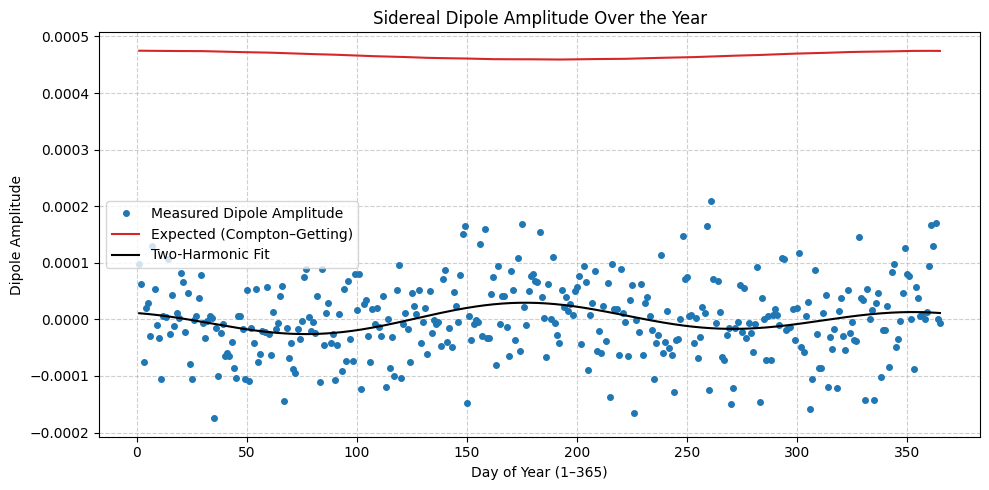

In [7]:
# Imports
import os
from datetime import datetime

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from astropy import units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, get_body_barycentric_posvel

from mapFunctions import getMap 

# Constants & Paths
DAILY_DIR      = '/data/user/fmcnally/anisotropy/maps/merged_daily'
ALL_DATA_FILE  = '/data/user/fmcnally/anisotropy/maps/merged/IC86_N10_sid.fits'
AXIAL_TILT_DEG = 23.44              # Earth’s axial tilt
CR_GAMMA       = 2.7                # Cosmic-ray spectral index
C_KM_S         = 299_792.458        # Speed of light (km/s)
DECLINATION_DEG = -24.33            # Effective declination of IceCube dipole projection
PROJECTION_CORRECTION = 1 / np.cos(np.radians(DECLINATION_DEG))

# Helper Functions
def axial_tilt_phase(day_of_year: int) -> float:
    return np.radians(AXIAL_TILT_DEG * np.sin(2 * np.pi * (day_of_year - 81) / 365.25))

def cos_func(ra_deg, amplitude, phase):
    """Simple cosine model in degrees → relint."""
    return amplitude * np.cos(np.radians(ra_deg) + phase)

def ra_projection_fov(relint_map, relerr_map, nbins=24, nside=None):
    """Project a full-sky map into RA bins restricted to IceCube field of view."""
    npix  = len(relint_map)
    nside = nside or hp.npix2nside(npix)
    theta, phi = hp.pix2ang(nside, np.arange(npix))

    # IceCube FoV (zenith 90°–120° → colatitude 90°–120°)
    fov_mask = (theta >= np.radians(90)) & (theta <= np.radians(120))

    # RA in degrees
    ra = np.degrees(phi)
    bins = np.linspace(0, 360, nbins + 1)
    digitized = np.digitize(ra, bins) - 1

    ri, err = np.empty(nbins), np.empty(nbins)
    for i in range(nbins):
        pixmask = (digitized == i) & fov_mask & np.isfinite(relint_map) & (relint_map != hp.UNSEEN)
        if np.any(pixmask):
            ri[i]  = np.mean(relint_map[pixmask])
            err[i] = np.sqrt(np.sum(relerr_map[pixmask]**2)) / np.sum(pixmask)
        else:
            ri[i] = err[i] = np.nan

    ra_centers = 0.5 * (bins[:-1] + bins[1:])
    return ra_centers, ri, err

def expected_amplitude_astropy(utc_date: datetime) -> float:
    """Return the Compton–Getting amplitude for a given UTC date."""
    t = Time(utc_date, scale='utc')
    with solar_system_ephemeris.set('builtin'):
        _, vel = get_body_barycentric_posvel('earth', t)
    v_mag = vel.norm().to(u.km/u.s).value   # km/s
    return (CR_GAMMA + 2) * (v_mag / C_KM_S)

# Load reference (full-year) map
all_relint = getMap([ALL_DATA_FILE], mapName='relint', smooth=20,
                    verbose=False, mask=True)

# Main daily loop 
amplitudes, expected_amps, days_of_year = [], [], []

for doy in range(1, 366):
    try:
        date = datetime.strptime(f'2025-{doy:03d}', '%Y-%j')  # any non-leap year is fine
        month_str, day_str = f'{date.month:02d}', f'{date.day:02d}'
    except ValueError:
        continue  # should not occur for 1–365

    filename = f"{DAILY_DIR}/IC86_N10_sid_{month_str}-{day_str}.fits"
    if not os.path.isfile(filename):
        print(f"Missing map for DOY {doy} → {filename}")
        continue

    try:
        relint_day = getMap([filename], mapName='relint', smooth=20,
                            verbose=False, mask=True)
        if relint_day is None or all_relint is None:
            continue

        diff_map = relint_day - all_relint
        nside = hp.get_nside(diff_map)

        # Mask invalid pixels outside FoV
        theta, _ = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
        mask = (
            (theta < np.radians(90)) | (theta > np.radians(120)) |
            (~np.isfinite(diff_map)) | (diff_map == 0) | (diff_map == hp.UNSEEN)
        )
        diff_map[mask] = hp.UNSEEN
        err_map = np.full_like(diff_map, 1e-5)

        ra_vals, ri_vals, _ = ra_projection_fov(diff_map, err_map, nbins=24, nside=nside)

        # Fit cosine to RA profile
        fit_mask = np.isfinite(ri_vals)
        if np.sum(fit_mask) < 5:
            print(f"Too few valid RA bins on DOY {doy}")
            continue

        popt, _ = curve_fit(cos_func, ra_vals[fit_mask], ri_vals[fit_mask],
                            p0=[1e-3, axial_tilt_phase(doy)])
        
        amplitude_raw = abs(popt[0])
        amplitude_corrected = amplitude_raw * PROJECTION_CORRECTION
        
        amplitudes.append(amplitude_corrected)
        days_of_year.append(doy)

        # Expected CG amplitude
        expected_amps.append(expected_amplitude_astropy(date))

    except Exception as e:
        print(f"Error processing DOY {doy}: {e}")
        continue
# Two-harmonic model definition
def two_harmonic_model(day, A1, phi1, A2, phi2):
    omega = 2 * np.pi / 365.25
    return A1 * np.cos(omega * day - phi1) + A2 * np.cos(2 * omega * day - phi2)

# Fit two-harmonic model to measured amplitudes
fit_mask = np.isfinite(amplitudes)
doy_array = np.array(days_of_year)[fit_mask]
amp_array = np.array(amplitudes)[fit_mask]
np.mean(amp_array)
mean_amp=np.mean(amp_array)
amp_array-=mean_amp
popt, _ = curve_fit(two_harmonic_model, doy_array, amp_array, p0=[4e-4, 0.0, 1e-4, 0.0])
A1, phi1, A2, phi2 = popt
fit_curve = two_harmonic_model(doy_array, *popt)

print(f"Fit parameters:")
print(f"  A1     = {A1:.4e}")
print(f"  phi1   = {phi1:.2f} rad")
print(f"  A2     = {A2:.4e}")
print(f"  phi2   = {phi2:.2f} rad")

# Plot results
plt.figure(figsize=(10, 5))

# 1) Measured amplitudes
plt.plot(days_of_year, amp_array, 'o', markersize=4, label='Measured Dipole Amplitude', color='tab:blue')

# 2) Expected CG amplitude
plt.plot(days_of_year, expected_amps, '-', linewidth=1.5, label='Expected (Compton–Getting)', color='tab:red')

# 3) Fitted two-harmonic model
plt.plot(doy_array, fit_curve, '-', color='black', linewidth=1.5, label='Two-Harmonic Fit')

plt.xlabel('Day of Year (1–365)')
plt.ylabel('Dipole Amplitude')
plt.title('Sidereal Dipole Amplitude Over the Year')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('dipole_amplitude_full_year_two_harmonic.png', dpi=300)
plt.show()

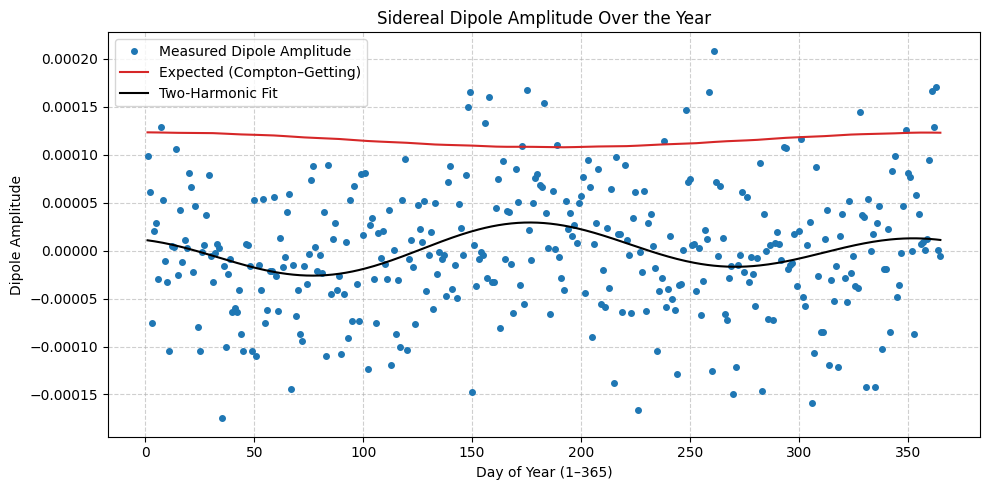

In [4]:
plt.figure(figsize=(10, 5))

# 1) Measured amplitudes
plt.plot(days_of_year, amp_array, 'o', markersize=4, label='Measured Dipole Amplitude', color='tab:blue')

# 2) Expected CG amplitude
plt.plot(days_of_year, expected_amps- mean_amp, '-', linewidth=1.5, label='Expected (Compton–Getting)', color='tab:red')

# 3) Fitted two-harmonic model
plt.plot(doy_array, fit_curve, '-', color='black', linewidth=1.5, label='Two-Harmonic Fit')

plt.xlabel('Day of Year (1–365)')
plt.ylabel('Dipole Amplitude')
plt.title('Sidereal Dipole Amplitude Over the Year')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('dipole_amplitude_full_year_two_harmonic.png', dpi=300)
plt.show()   

In [5]:
popt, _ = curve_fit(two_harmonic_model, doy_array, amp_array, p0=[4e-4, 0.0, 1e-4, 0.0])


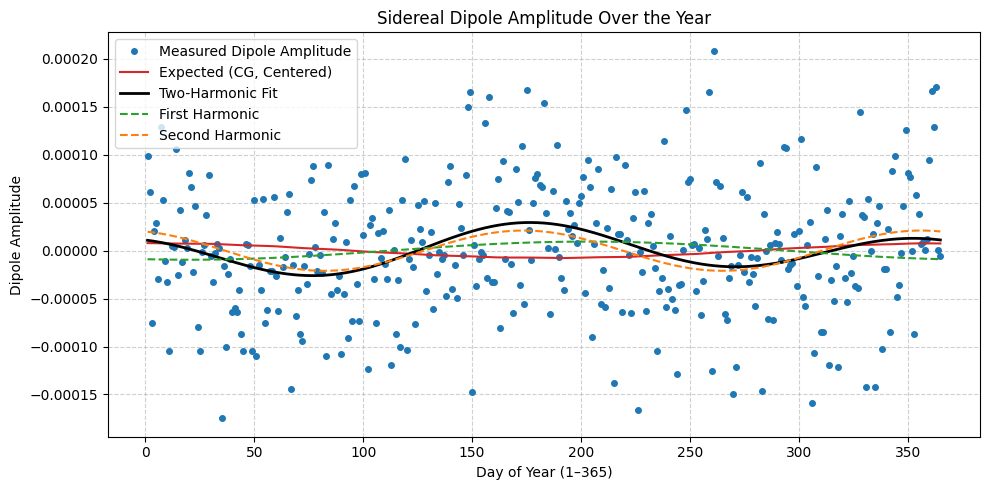

In [9]:
# Define harmonic components
def first_harmonic(day, A1, phi1):
    omega = 2 * np.pi / 365.25
    return A1 * np.cos(omega * day - phi1)

def second_harmonic(day, A2, phi2):
    omega = 2 * np.pi / 365.25
    return A2 * np.cos(2 * omega * day - phi2)

# Unpack fit parameters
A1, phi1, A2, phi2 = popt

# Compute harmonic curves
fit_curve  = first_harmonic(doy_array, A1, phi1) + second_harmonic(doy_array, A2, phi2)
fit_curve1 = first_harmonic(doy_array, A1, phi1)
fit_curve2 = second_harmonic(doy_array, A2, phi2)

# Center expected CG amplitude around zero
cg_amps = np.array(expected_amps)
cg_centered = cg_amps - np.mean(cg_amps)

# Plotting
plt.figure(figsize=(10, 5))

# 1) Measured amplitudes
plt.plot(days_of_year, amp_array, 'o', markersize=4, label='Measured Dipole Amplitude', color='tab:blue')

# 2) Centered CG amplitude
plt.plot(days_of_year, cg_centered, '-', linewidth=1.5, color='tab:red', label='Expected (CG, Centered)')

# 3) Full two-harmonic fit
plt.plot(doy_array, fit_curve, '-', color='black', linewidth=2, label='Two-Harmonic Fit')

# 4) First harmonic
plt.plot(doy_array, fit_curve1, '--', color='tab:green', linewidth=1.5, label='First Harmonic')

# 5) Second harmonic
plt.plot(doy_array, fit_curve2, '--', color='tab:orange', linewidth=1.5, label='Second Harmonic')

# --- Plot labels and formatting ---
plt.xlabel('Day of Year (1–365)')
plt.ylabel('Dipole Amplitude')
plt.title('Sidereal Dipole Amplitude Over the Year')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('dipole_amplitude_full_year_two_harmonic_split.png', dpi=300)
plt.show()


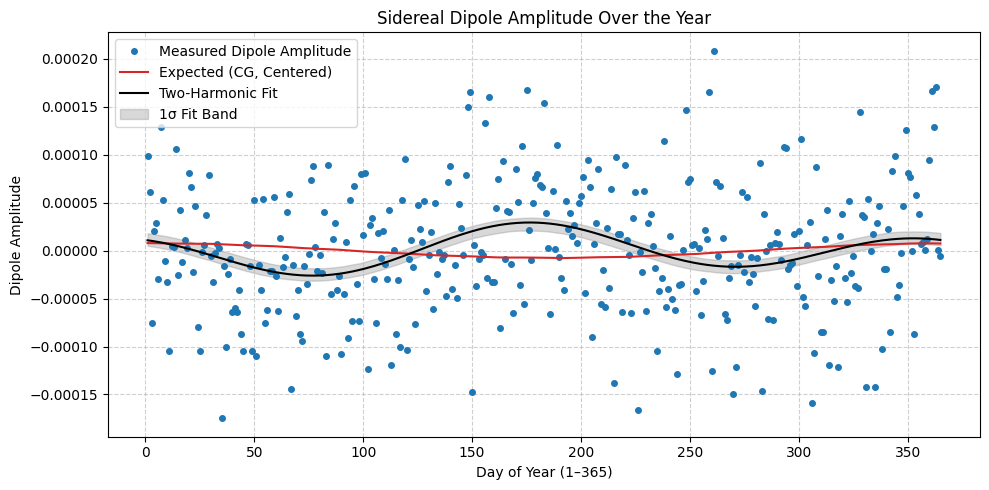


Fit parameters with 1σ uncertainties:
  A1     = -9.4788e-06 ± 4.8e-06
  phi1   = 0.35 ± 0.51 rad
  A2     = 2.1013e-05 ± 4.8e-06
  phi2   = -0.31 ± 0.23 rad


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Two-harmonic model
def two_harmonic_model(day, A1, phi1, A2, phi2):
    omega = 2 * np.pi / 365.25
    return A1 * np.cos(omega * day - phi1) + A2 * np.cos(2 * omega * day - phi2)

#Fit with error estimation
popt, pcov = curve_fit(two_harmonic_model, doy_array, amp_array, p0=[4e-4, 0.0, 1e-4, 0.0])
perr = np.sqrt(np.diag(pcov))

A1, phi1, A2, phi2 = popt
σ_A1, σ_phi1, σ_A2, σ_phi2 = perr

# Compute fit curve and error band
fit_curve = two_harmonic_model(doy_array, *popt)

# Monte Carlo sampling to get error bands
N_samples = 1000
rng = np.random.default_rng(seed=42)
samples = rng.multivariate_normal(popt, pcov, size=N_samples)
fit_samples = np.array([two_harmonic_model(doy_array, *params) for params in samples])

fit_upper = np.percentile(fit_samples, 84, axis=0)  # +1σ
fit_lower = np.percentile(fit_samples, 16, axis=0)  # -1σ

# Center expected CG amplitude around zero
cg_amps = np.array(expected_amps)
cg_centered = cg_amps - np.mean(cg_amps)

# Plotting
plt.figure(figsize=(10, 5))

# 1) Measured amplitudes
plt.plot(doy_array, amp_array, 'o', markersize=4, label='Measured Dipole Amplitude', color='tab:blue')

# 2) Centered CG amplitude
plt.plot(days_of_year, cg_centered, '-', linewidth=1.5, color='tab:red', label='Expected (CG, Centered)')

# 3) Two-harmonic fit
plt.plot(doy_array, fit_curve, '-', color='black', linewidth=1.5, label='Two-Harmonic Fit')

# 4) Error band (1σ)
plt.fill_between(doy_array, fit_lower, fit_upper, color='gray', alpha=0.3, label='1σ Fit Band')

plt.xlabel('Day of Year (1–365)')
plt.ylabel('Dipole Amplitude')
plt.title('Sidereal Dipole Amplitude Over the Year')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('dipole_amplitude_with_uncertainty_band.png', dpi=300)
plt.show()

# Print fit summary
print("\nFit parameters with 1σ uncertainties:")
print(f"  A1     = {A1:.4e} ± {σ_A1:.1e}")
print(f"  phi1   = {phi1:.2f} ± {σ_phi1:.2f} rad")
print(f"  A2     = {A2:.4e} ± {σ_A2:.1e}")
print(f"  phi2   = {phi2:.2f} ± {σ_phi2:.2f} rad")

In [3]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
from mapFunctions import getMap  # Ensure this is available

# directories
daily_dir = '/data/user/fmcnally/anisotropy/maps/merged_daily'
all_data_file = '/data/user/fmcnally/anisotropy/maps/merged/IC86_N10_sid.fits'

# Geometric correction factors
delta_min = np.radians(-90)
delta_max = np.radians(-30)
numerator = 2 * (np.sin(delta_min) - np.sin(delta_max))
denominator = (
    delta_min - delta_max +
    np.cos(delta_min) * np.sin(delta_min) -
    np.cos(delta_max) * np.sin(delta_max)
)
correction_factor = numerator / denominator  # Same as in monthly analysis

# Axial tilt correction
epsilon = np.radians(23.44)
rot_x = np.array([
    [1, 0, 0],
    [0, np.cos(epsilon), -np.sin(epsilon)],
    [0, np.sin(epsilon),  np.cos(epsilon)]
])
dipole_equatorial = rot_x @ np.array([0, 0, 1])
x_eq, y_eq, _ = dipole_equatorial
tilt_ra_offset = np.degrees(np.arctan2(y_eq, x_eq)) % 360
tilt_ra_shift = (tilt_ra_offset - 180) % 360

# COsine Model
def cos_func(x, A, phi):
    return A * np.cos(np.radians(x) + phi)

# RA Projection in Declination FoV
def ra_projection_fov(relint_map, relerr_map, nbins=24, nside=None):
    npix = len(relint_map)
    if nside is None:
        nside = hp.npix2nside(npix)
    theta, phi = hp.pix2ang(nside, np.arange(npix))
    fov_mask = (theta >= np.radians(90)) & (theta <= np.radians(120))
    ra = phi * 180 / np.pi
    bins = np.linspace(0, 360, nbins + 1)
    digitized = np.digitize(ra, bins) - 1
    ri = np.zeros(nbins)
    err = np.zeros(nbins)
    for i in range(nbins):
        mask = (digitized == i) & (relint_map != hp.UNSEEN) & fov_mask
        if np.any(mask):
            ri[i] = np.mean(relint_map[mask])
            err[i] = np.sqrt(np.sum(relerr_map[mask]**2)) / np.sum(mask)
        else:
            ri[i] = np.nan
            err[i] = np.nan
    ra_centers = 0.5 * (bins[:-1] + bins[1:])
    return ra_centers, ri, err

# Day-of-Year Ranges by Month
month_days = {
    '01': (1, 31),
    '02': (32, 59),  # Non-leap year
    '03': (60, 90),
    '04': (91, 120),
    '05': (121, 151),
    '06': (152, 181),
    '07': (182, 212),
    '08': (213, 243),
    '09': (244, 273),
    '10': (274, 304),
    '11': (305, 334),
    '12': (335, 365),
}

# Load Reference Map
all_relint = getMap([all_data_file], mapName='relint', smooth=10, verbose=False, mask=True)

# Storage for Yearly Aggregation
daily_amplitudes = []
daily_phases = []
days_of_year = []

# Loop Over All Days
for month_str, (start_doy, end_doy) in month_days.items():
    for i, doy in enumerate(range(start_doy, end_doy + 1)):
        day = i + 1
        filename = f"{daily_dir}/IC86_N10_sid_{month_str}-{day:02d}.fits"
        if not os.path.isfile(filename):
            print(f"Missing: {filename}")
            continue
        try:
            relint_day = getMap([filename], mapName='relint', smooth=10, verbose=False, mask=True)
            if relint_day is None or all_relint is None:
                continue

            # Diff map and masking
            diff_map = relint_day - all_relint
            nside = hp.get_nside(diff_map)
            npix = hp.nside2npix(nside)
            theta, _ = hp.pix2ang(nside, np.arange(npix))
            mask = (
                (theta < np.radians(90)) |
                (theta > np.radians(120)) |
                (~np.isfinite(diff_map)) |
                (diff_map == 0) |
                (diff_map == hp.UNSEEN)
            )
            diff_map[mask] = hp.UNSEEN
            err_map = np.full_like(diff_map, 1e-5)  # Placeholder errors

            # RA projection
            ra_vals, ri_vals, ri_err = ra_projection_fov(diff_map, err_map, nbins=24, nside=nside)
            mask_fit = np.isfinite(ri_vals)
            if np.sum(mask_fit) < 5:
                continue

            # Fit dipole model
            popt, _ = curve_fit(cos_func, ra_vals[mask_fit], ri_vals[mask_fit], p0=[1e-3, 0])
            A_raw, phi_raw = popt
            A_corr = abs(A_raw) * correction_factor
            RA_phase = np.degrees(phi_raw) % 360
            RA_phase_corr = (RA_phase + tilt_ra_shift) % 360

            # Store
            daily_amplitudes.append(A_corr)
            daily_phases.append(RA_phase_corr)
            days_of_year.append(doy)

        except Exception as e:
            print(f"Error on {month_str}-{day:02d}: {e}")
            continue

# Plot Daily Amplitude Over Year
plt.figure(figsize=(10, 5))
plt.plot(days_of_year, daily_amplitudes, 'o', markersize=4, color='tab:blue', label='Corrected Amplitude')
plt.axhline(4e-4, color='gray', linestyle='--', label='Expected ~4×10⁻⁴')
plt.xlabel('Day of Year')
plt.ylabel('Dipole Amplitude $A_1^\\dagger$')
plt.title('Daily Solar Dipole Amplitude (Corrected)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("daily_dipole_amplitude_all_year.png", dpi=300)
plt.close()

# Plot RA Phase Over Year
plt.figure(figsize=(10, 5))
plt.plot(days_of_year, daily_phases, 'o', markersize=4, color='tab:red', label='RA Phase (Corrected)')
plt.xlabel('Day of Year')
plt.ylabel('RA Phase [deg]')
plt.title('Daily Dipole RA Phase (Axial Tilt Corrected)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("daily_dipole_phase_all_year.png", dpi=300)
plt.close()
plt.show()

Fit parameters:
  A    = 4.2027e-05
  phi1 = -0.16 rad
  B    = -9.4788e-06
  phi2 = 0.35 rad
  C    = 2.2161e+00


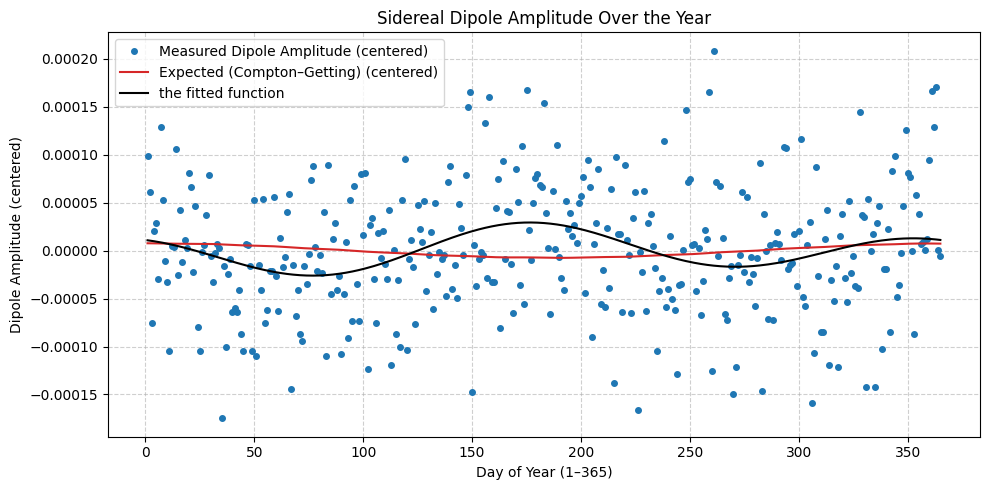

In [6]:
# Imports
import os
from datetime import datetime

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from astropy import units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, get_body_barycentric_posvel

from mapFunctions import getMap 

# Constants & Paths
DAILY_DIR      = '/data/user/fmcnally/anisotropy/maps/merged_daily'
ALL_DATA_FILE  = '/data/user/fmcnally/anisotropy/maps/merged/IC86_N10_sid.fits'
AXIAL_TILT_DEG = 23.44              # Earth’s axial tilt
CR_GAMMA       = 2.6                # Cosmic-ray spectral index
C_KM_S         = 299_792.458        # Speed of light (km/s)
DECLINATION_DEG = -24.33            # Effective declination of IceCube dipole projection
PROJECTION_CORRECTION = 1 / np.cos(np.radians(DECLINATION_DEG))

# Helper Functions
def axial_tilt_phase(day_of_year: int) -> float:
    return np.radians(AXIAL_TILT_DEG * np.sin(2 * np.pi * (day_of_year - 81) / 365.25))

def cos_func(ra_deg, amplitude, phase):
    """Simple cosine model in degrees → relint."""
    return amplitude * np.cos(np.radians(ra_deg) + phase)

def ra_projection_fov(relint_map, relerr_map, nbins=24, nside=None):
    """Project a full-sky map into RA bins restricted to IceCube field of view."""
    npix  = len(relint_map)
    nside = nside or hp.npix2nside(npix)
    theta, phi = hp.pix2ang(nside, np.arange(npix))

    # IceCube FoV (zenith 90°–120° → colatitude 90°–120°)
    fov_mask = (theta >= np.radians(90)) & (theta <= np.radians(120))

    # RA in degrees
    ra = np.degrees(phi)
    bins = np.linspace(0, 360, nbins + 1)
    digitized = np.digitize(ra, bins) - 1

    ri, err = np.empty(nbins), np.empty(nbins)
    for i in range(nbins):
        pixmask = (digitized == i) & fov_mask & np.isfinite(relint_map) & (relint_map != hp.UNSEEN)
        if np.any(pixmask):
            ri[i]  = np.mean(relint_map[pixmask])
            err[i] = np.sqrt(np.sum(relerr_map[pixmask]**2)) / np.sum(pixmask)
        else:
            ri[i] = err[i] = np.nan

    ra_centers = 0.5 * (bins[:-1] + bins[1:])
    return ra_centers, ri, err

def expected_amplitude_astropy(utc_date: datetime) -> float:
    """Return the Compton–Getting amplitude for a given UTC date."""
    t = Time(utc_date, scale='utc')
    with solar_system_ephemeris.set('builtin'):
        _, vel = get_body_barycentric_posvel('earth', t)
    v_mag = vel.norm().to(u.km/u.s).value   # km/s
    return (CR_GAMMA + 2) * (v_mag / C_KM_S)

# Load reference (full-year) map
all_relint = getMap([ALL_DATA_FILE], mapName='relint', smooth=20,
                    verbose=False, mask=True)

# Main daily loop 
amplitudes, expected_amps, days_of_year = [], [], []

for doy in range(1, 366):
    try:
        date = datetime.strptime(f'2025-{doy:03d}', '%Y-%j')  # any non-leap year is fine
        month_str, day_str = f'{date.month:02d}', f'{date.day:02d}'
    except ValueError:
        continue  # should not occur for 1–365

    filename = f"{DAILY_DIR}/IC86_N10_sid_{month_str}-{day_str}.fits"
    if not os.path.isfile(filename):
        print(f"Missing map for DOY {doy} → {filename}")
        continue

    try:
        relint_day = getMap([filename], mapName='relint', smooth=20,
                            verbose=False, mask=True)
        if relint_day is None or all_relint is None:
            continue

        diff_map = relint_day - all_relint
        nside = hp.get_nside(diff_map)

        # Mask invalid pixels outside FoV
        theta, _ = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
        mask = (
            (theta < np.radians(90)) | (theta > np.radians(120)) |
            (~np.isfinite(diff_map)) | (diff_map == 0) | (diff_map == hp.UNSEEN)
        )
        diff_map[mask] = hp.UNSEEN
        err_map = np.full_like(diff_map, 1e-5)

        ra_vals, ri_vals, _ = ra_projection_fov(diff_map, err_map, nbins=24, nside=nside)

        # Fit cosine to RA profile
        fit_mask = np.isfinite(ri_vals)
        if np.sum(fit_mask) < 5:
            print(f"Too few valid RA bins on DOY {doy}")
            continue

        popt, _ = curve_fit(cos_func, ra_vals[fit_mask], ri_vals[fit_mask],
                            p0=[1e-3, axial_tilt_phase(doy)])
        
        amplitude_raw = abs(popt[0])
        amplitude_corrected = amplitude_raw * PROJECTION_CORRECTION
        
        amplitudes.append(amplitude_corrected)
        days_of_year.append(doy)

        # Expected CG amplitude
        expected_amps.append(expected_amplitude_astropy(date))

    except Exception as e:
        print(f"Error processing DOY {doy}: {e}")
        continue

# New custom model definition
def custom_model(day, A, phi1, B, phi2, C):
    omega = 2 * np.pi / 365.25
    return A * (np.cos(omega * day - phi1))**2 + B * (np.cos(omega * day - phi2) + C)

# Fit custom model to measured amplitudes
fit_mask = np.isfinite(amplitudes)
doy_array = np.array(days_of_year)[fit_mask]
amp_array = np.array(amplitudes)[fit_mask]

# Remove mean to center data around zero for better fit stability
mean_amp = np.mean(amp_array)
amp_array_centered = amp_array - mean_amp

# Initial guess for parameters: A, phi1, B, phi2, C
p0 = [4e-4, 0.0, 1e-4, 0.0, 0.0]

popt, _ = curve_fit(custom_model, doy_array, amp_array_centered, p0=p0)
A, phi1, B, phi2, C = popt
fit_curve = custom_model(doy_array, *popt)

print(f"Fit parameters:")
print(f"  A    = {A:.4e}")
print(f"  phi1 = {phi1:.2f} rad")
print(f"  B    = {B:.4e}")
print(f"  phi2 = {phi2:.2f} rad")
print(f"  C    = {C:.4e}")

# Plot results
plt.figure(figsize=(10, 5))

# Measured amplitudes centered
plt.plot(days_of_year, amp_array_centered, 'o', markersize=4, label='Measured Dipole Amplitude (centered)', color='tab:blue')

# Expected CG amplitude centered
expected_amps_centered = np.array(expected_amps)[fit_mask] - np.mean(expected_amps)
plt.plot(doy_array, expected_amps_centered, '-', linewidth=1.5, label='Expected (Compton–Getting) (centered)', color='tab:red')

# Fitted custom model
plt.plot(doy_array, fit_curve, '-', color='black', linewidth=1.5, label='the fitted function')

plt.xlabel('Day of Year (1–365)')
plt.ylabel('Dipole Amplitude (centered)')
plt.title('Sidereal Dipole Amplitude Over the Year')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('dipole_amplitude_custom_model_fit.png', dpi=300)
plt.show()

Fit parameters (no mean subtraction):
  A    = 4.2027e-05
  phi1 = -0.16 rad
  B    = 9.4788e-06
  phi2 = -2.79 rad
  C    = 3.4852e+01


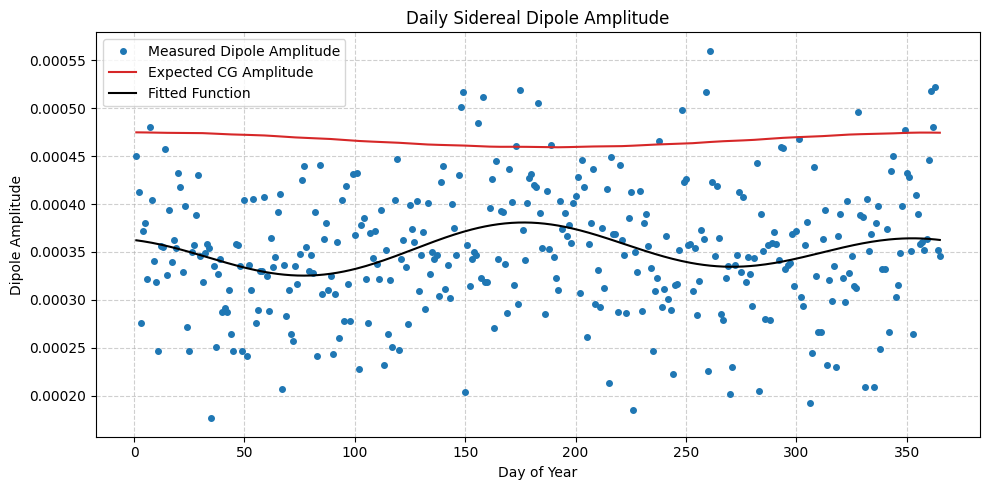

In [1]:
import os
from datetime import datetime

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from astropy import units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, get_body_barycentric_posvel

from mapFunctions import getMap

# --- Constants & Paths ---
DAILY_DIR      = '/data/user/fmcnally/anisotropy/maps/merged_daily'
ALL_DATA_FILE  = '/data/user/fmcnally/anisotropy/maps/merged/IC86_N10_sid.fits'
AXIAL_TILT_DEG = 23.44
CR_GAMMA       = 2.7
C_KM_S         = 299_792.458
DECLINATION_DEG = -24.33
PROJECTION_CORRECTION = 1 / np.cos(np.radians(DECLINATION_DEG))

# --- Functions ---
def axial_tilt_phase(day_of_year: int) -> float:
    return np.radians(AXIAL_TILT_DEG * np.sin(2 * np.pi * (day_of_year - 81) / 365.25))

def cos_func(ra_deg, amplitude, phase):
    return amplitude * np.cos(np.radians(ra_deg) + phase)

def ra_projection_fov(relint_map, relerr_map, nbins=24, nside=None):
    npix = len(relint_map)
    nside = nside or hp.npix2nside(npix)
    theta, phi = hp.pix2ang(nside, np.arange(npix))

    fov_mask = (theta >= np.radians(90)) & (theta <= np.radians(120))
    ra = np.degrees(phi)
    bins = np.linspace(0, 360, nbins + 1)
    digitized = np.digitize(ra, bins) - 1

    ri, err = np.empty(nbins), np.empty(nbins)
    for i in range(nbins):
        pixmask = (digitized == i) & fov_mask & np.isfinite(relint_map) & (relint_map != hp.UNSEEN)
        if np.any(pixmask):
            ri[i]  = np.mean(relint_map[pixmask])
            err[i] = np.sqrt(np.sum(relerr_map[pixmask]**2)) / np.sum(pixmask)
        else:
            ri[i] = err[i] = np.nan

    ra_centers = 0.5 * (bins[:-1] + bins[1:])
    return ra_centers, ri, err

def expected_amplitude_astropy(utc_date: datetime) -> float:
    t = Time(utc_date, scale='utc')
    with solar_system_ephemeris.set('builtin'):
        _, vel = get_body_barycentric_posvel('earth', t)
    v_mag = vel.norm().to(u.km/u.s).value
    return (CR_GAMMA + 2) * (v_mag / C_KM_S)

# --- Custom Fit Model ---
def custom_model(day, A, phi1, B, phi2, C):
    omega = 2 * np.pi / 365.25
    return A * (np.cos(omega * day - phi1))**2 + B * (np.cos(omega * day - phi2) + C)

# --- Load full-year map for subtraction ---
all_relint = getMap([ALL_DATA_FILE], mapName='relint', smooth=20, verbose=False, mask=True)

# --- Main loop over days ---
amplitudes, expected_amps, days_of_year = [], [], []

for doy in range(1, 366):
    try:
        date = datetime.strptime(f'2025-{doy:03d}', '%Y-%j')
        month_str, day_str = f'{date.month:02d}', f'{date.day:02d}'
    except ValueError:
        continue

    filename = f"{DAILY_DIR}/IC86_N10_sid_{month_str}-{day_str}.fits"
    if not os.path.isfile(filename):
        print(f"Missing map for DOY {doy}")
        continue

    try:
        relint_day = getMap([filename], mapName='relint', smooth=20, verbose=False, mask=True)
        if relint_day is None or all_relint is None:
            continue

        diff_map = relint_day - all_relint
        nside = hp.get_nside(diff_map)
        theta, _ = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))

        mask = (
            (theta < np.radians(90)) | (theta > np.radians(120)) |
            (~np.isfinite(diff_map)) | (diff_map == 0) | (diff_map == hp.UNSEEN)
        )
        diff_map[mask] = hp.UNSEEN
        err_map = np.full_like(diff_map, 1e-5)

        ra_vals, ri_vals, _ = ra_projection_fov(diff_map, err_map, nbins=24, nside=nside)
        fit_mask = np.isfinite(ri_vals)
        if np.sum(fit_mask) < 5:
            continue

        popt, _ = curve_fit(cos_func, ra_vals[fit_mask], ri_vals[fit_mask],
                            p0=[1e-3, axial_tilt_phase(doy)])
        amplitude_raw = abs(popt[0])
        amplitude_corrected = amplitude_raw * PROJECTION_CORRECTION

        amplitudes.append(amplitude_corrected)
        expected_amps.append(expected_amplitude_astropy(date))
        days_of_year.append(doy)

    except Exception as e:
        print(f"Error on DOY {doy}: {e}")
        continue

# --- Fit the raw  amplitude data ---
doy_array = np.array(days_of_year)
amp_array = np.array(amplitudes)

# Initial parameter guess
p0 = [4e-4, 0.0, 1e-4, 0.0, 0.0]
popt, _ = curve_fit(custom_model, doy_array, amp_array, p0=p0)
A, phi1, B, phi2, C = popt
fit_curve = custom_model(doy_array, *popt)

# --- Print fit parameters ---
print(f"Fit parameters (no mean subtraction):")
print(f"  A    = {A:.4e}")
print(f"  phi1 = {phi1:.2f} rad")
print(f"  B    = {B:.4e}")
print(f"  phi2 = {phi2:.2f} rad")
print(f"  C    = {C:.4e}")

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(doy_array, amp_array, 'o', markersize=4, label='Measured Dipole Amplitude', color='tab:blue')
plt.plot(doy_array, np.array(expected_amps), '-', label='Expected CG Amplitude', color='tab:red')
plt.plot(doy_array, fit_curve, '-', label='Fitted Function', color='black')

plt.xlabel('Day of Year')
plt.ylabel('Dipole Amplitude')
plt.title('Daily Sidereal Dipole Amplitude')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('dipole_amplitude_no_centering_fit.png', dpi=300)
plt.show()



Fit parameters:
  A    = 4.2807e-05
  phi1 = -0.11 rad
  B    = -1.2682e-05
  phi2 = 0.79 rad
  C    = 3.9871e-04 (baseline amplitude)
  Mean amplitude = 4.2011e-04


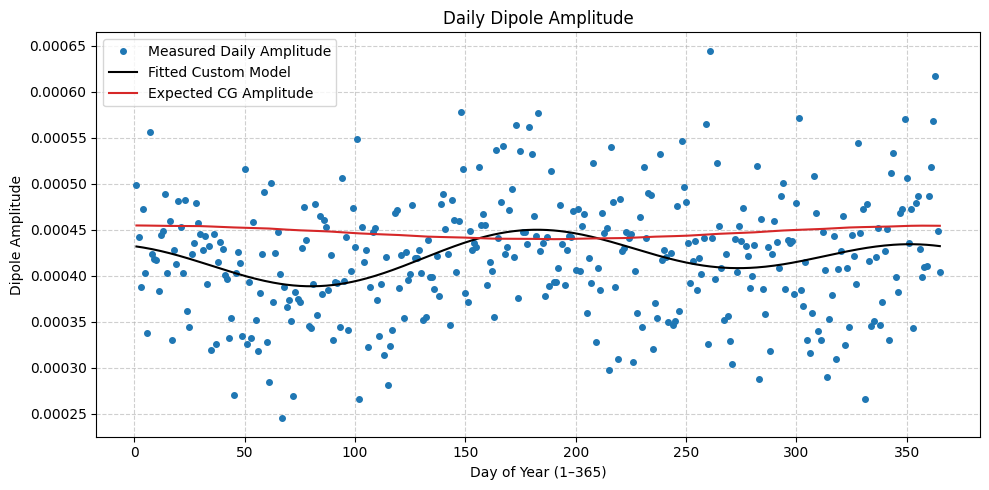

In [1]:
import os
from datetime import datetime
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, get_body_barycentric_posvel

from mapFunctions import getMap

# --- Constants ---
DAILY_DIR = '/data/user/fmcnally/anisotropy/maps/merged_daily'
ALL_DATA_FILE = '/data/user/fmcnally/anisotropy/maps/merged/IC86_N10_sid.fits'
CR_GAMMA = 2.5
C_KM_S = 299_792.458  # Speed of light
NBINS_RA = 24

# Declination correction factor (same as monthly code)
delta_min = np.radians(-90)
delta_max = np.radians(-30)
numerator = 2 * (np.sin(delta_min) - np.sin(delta_max))
denominator = (
    delta_min - delta_max +
    np.cos(delta_min) * np.sin(delta_min) -
    np.cos(delta_max) * np.sin(delta_max)
)
correction_factor = numerator / denominator

# Projection angle for CG effect
epsilon = np.radians(23.4)

# Dipole model
def acos_func(x, A, phi):
    return A * np.cos(np.radians(x) + phi)

# RA projection (copied from monthly)
def returnRI(relint_map, relerr_map, ramin=0, ramax=360, nbins=24):
    degree = np.pi / 180
    ramin *= degree
    ramax *= degree
    rabins = np.linspace(ramin, ramax, nbins + 1)
    nside = hp.npix2nside(len(relint_map))
    theta, phi = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
    phiBins = np.digitize(phi, rabins) - 1
    cut = (relint_map != hp.UNSEEN)

    ri, sigmay = np.zeros((2, nbins))
    for i in range(nbins):
        phiCut = (phiBins == i)
        c0 = cut * phiCut
        if np.any(c0):
            ri[i] = np.mean(relint_map[c0])
            sigmay[i] = np.sqrt(np.sum(relerr_map[c0] ** 2)) / c0.sum()
        else:
            ri[i] = sigmay[i] = np.nan

    dx = (ramax - ramin) / (2 * nbins)
    ra = np.linspace(ramin + dx, ramax - dx, nbins) / degree
    return ra, ri, dx * np.ones(nbins) / degree, sigmay

# CG expected amplitude using Earth velocity from astropy
def expected_amplitude_astropy(utc_date):
    t = Time(utc_date, scale='utc')
    with solar_system_ephemeris.set('builtin'):
        _, vel = get_body_barycentric_posvel('earth', t)
    v_mag = vel.norm().to(u.km/u.s).value
    return (CR_GAMMA + 2) * (v_mag / C_KM_S)

# Load full-year average map
all_relint = getMap([ALL_DATA_FILE], mapName='relint', smooth=10, verbose=False, mask=True)

# Main loop over each day
amplitudes_raw, amplitudes_corr, expected_amps, days_of_year = [], [], [], []

for doy in range(1, 366):
    try:
        date = datetime.strptime(f'2025-{doy:03d}', '%Y-%j')
        fn = f"{DAILY_DIR}/IC86_N10_sid_{date.month:02d}-{date.day:02d}.fits"
        if not os.path.isfile(fn):
            continue

        relint_day = getMap([fn], mapName='relint', smooth=10, verbose=False, mask=True)
        if relint_day is None or all_relint is None:
            continue

        diff_map = relint_day - all_relint
        nside = hp.get_nside(diff_map)
        theta, _ = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))

        # Apply southern sky mask
        mask = (theta < np.pi / 2) | (~np.isfinite(diff_map)) | (diff_map == 0) | (diff_map == hp.UNSEEN)
        diff_map[mask] = hp.UNSEEN
        err_map = np.full_like(diff_map, 1e-5)

        # Project to RA and fit cosine
        ra_vals, ri_vals, _, sigmay = returnRI(diff_map, err_map, ramin=0, ramax=360, nbins=NBINS_RA)
        fit_mask = np.isfinite(ri_vals)
        if np.sum(fit_mask) < 5:
            continue

        popt, _ = curve_fit(acos_func, ra_vals[fit_mask], ri_vals[fit_mask], sigma=sigmay[fit_mask],
                            bounds=([0, 0], [0.01, 2*np.pi]))
        A_raw, phi = popt

        # Apply declination + projection correction
        A_corr = correction_factor * A_raw

        amplitudes_raw.append(A_raw)
        amplitudes_corr.append(A_corr)
        expected_amps.append(expected_amplitude_astropy(date))
        days_of_year.append(doy)

    except Exception as e:
        print(f"[DOY {doy}] Error: {e}")
        continue

# Fit custom model (no mean subtraction)
def custom_model(day, A, phi1, B, phi2, C):
    omega = 2 * np.pi / 365.25
    return A * (np.cos(omega * day - phi1))**2 + B * np.cos(omega * day - phi2) + C

doy_array = np.array(days_of_year)
amp_array = np.array(amplitudes_corr)

p0 = [4e-4, 0.0, 1e-4, 0.0, 0.0]
popt, _ = curve_fit(custom_model, doy_array, amp_array, p0=p0)
A, phi1, B, phi2, C = popt
fit_curve = custom_model(doy_array, *popt)

# Print fit results
print(f"\nFit parameters:")
print(f"  A    = {A:.4e}")
print(f"  phi1 = {phi1:.2f} rad")
print(f"  B    = {B:.4e}")
print(f"  phi2 = {phi2:.2f} rad")
print(f"  C    = {C:.4e} (baseline amplitude)")
print(f"  Mean amplitude = {np.mean(amp_array):.4e}")

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(days_of_year, amp_array, 'o', markersize=4, label='Measured Daily Amplitude', color='tab:blue')
plt.plot(doy_array, fit_curve, '-', color='black', linewidth=1.5, label='Fitted Custom Model')
plt.plot(doy_array, np.array(expected_amps), '-', color='tab:red', linewidth=1.5, label='Expected CG Amplitude')

plt.xlabel('Day of Year (1–365)')
plt.ylabel('Dipole Amplitude')
plt.title('Daily Dipole Amplitude')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('daily_dipole_amplitude_nocenter.png', dpi=300)
plt.show()

In [ ]:
import os
from datetime import datetime
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, get_body_barycentric_posvel

from mapFunctions import getMap

# --- Constants ---
DAILY_DIR = '/data/user/fmcnally/anisotropy/maps/merged_daily'
ALL_DATA_FILE = '/data/user/fmcnally/anisotropy/maps/merged/IC86_N10_sid.fits'
CR_GAMMA = 2.5
C_KM_S = 299_792.458  # Speed of light
NBINS_RA = 24

# Declination correction factor (same as monthly code)
delta_min = np.radians(-90)
delta_max = np.radians(-30)
numerator = 2 * (np.sin(delta_min) - np.sin(delta_max))
denominator = (
    delta_min - delta_max +
    np.cos(delta_min) * np.sin(delta_min) -
    np.cos(delta_max) * np.sin(delta_max)
)
correction_factor = numerator / denominator

# Projection angle for CG effect
epsilon = np.radians(23.4)

# Dipole model
def acos_func(x, A, phi):
    return A * np.cos(np.radians(x) + phi)

# RA projection
def returnRI(relint_map, relerr_map, ramin=0, ramax=360, nbins=24):
    degree = np.pi / 180
    ramin *= degree
    ramax *= degree
    rabins = np.linspace(ramin, ramax, nbins + 1)
    nside = hp.npix2nside(len(relint_map))
    theta, phi = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
    phiBins = np.digitize(phi, rabins) - 1
    cut = (relint_map != hp.UNSEEN)

    ri, sigmay = np.zeros((2, nbins))
    for i in range(nbins):
        phiCut = (phiBins == i)
        c0 = cut * phiCut
        if np.any(c0):
            ri[i] = np.mean(relint_map[c0])
            sigmay[i] = np.sqrt(np.sum(relerr_map[c0] ** 2)) / c0.sum()
        else:
            ri[i] = sigmay[i] = np.nan

    dx = (ramax - ramin) / (2 * nbins)
    ra = np.linspace(ramin + dx, ramax - dx, nbins) / degree
    return ra, ri, dx * np.ones(nbins) / degree, sigmay

# CG expected amplitude using Earth velocity from astropy
def expected_amplitude_astropy(utc_date):
    t = Time(utc_date, scale='utc')
    with solar_system_ephemeris.set('builtin'):
        _, vel = get_body_barycentric_posvel('earth', t)
    v_mag = vel.norm().to(u.km/u.s).value
    return (CR_GAMMA + 2) * (v_mag / C_KM_S)

# Load full-year average map
all_relint = getMap([ALL_DATA_FILE], mapName='relint', smooth=10, verbose=False, mask=True)

# Main Loop 
amplitudes_raw, amplitudes_corr, expected_amps, days_of_year = [], [], [], []

for doy in range(1, 366):
    try:
        date = datetime.strptime(f'2025-{doy:03d}', '%Y-%j')
        fn = f"{DAILY_DIR}/IC86_N10_sid_{date.month:02d}-{date.day:02d}.fits"
        if not os.path.isfile(fn):
            continue

        relint_day = getMap([fn], mapName='relint', smooth=10, verbose=False, mask=True)
        if relint_day is None or all_relint is None:
            continue

        diff_map = relint_day - all_relint
        nside = hp.get_nside(diff_map)
        theta, _ = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))

        # Apply southern sky mask
        mask = (theta < np.pi / 2) | (~np.isfinite(diff_map)) | (diff_map == 0) | (diff_map == hp.UNSEEN)
        diff_map[mask] = hp.UNSEEN
        err_map = np.full_like(diff_map, 1e-5)

        # Project to RA and fit cosine
        ra_vals, ri_vals, _, sigmay = returnRI(diff_map, err_map, ramin=0, ramax=360, nbins=NBINS_RA)
        fit_mask = np.isfinite(ri_vals)
        if np.sum(fit_mask) < 5:
            continue

        popt, _ = curve_fit(acos_func, ra_vals[fit_mask], ri_vals[fit_mask], sigma=sigmay[fit_mask],
                            bounds=([0, 0], [0.01, 2*np.pi]))
        A_raw, phi = popt
        A_corr = correction_factor * A_raw

        amplitudes_raw.append(A_raw)
        amplitudes_corr.append(A_corr)
        expected_amps.append(expected_amplitude_astropy(date))
        days_of_year.append(doy)

    except Exception as e:
        print(f"[DOY {doy}] Error: {e}")
        continue

#  Fit Full Year Model
def custom_model(day, A, phi1, B, phi2, C):
    omega = 2 * np.pi / 365.25
    return A * (np.cos(omega * day - phi1))**2 + B * np.cos(omega * day - phi2) + C

doy_array = np.array(days_of_year)
amp_array = np.array(amplitudes_corr)

p0 = [4e-4, 0.0, 1e-4, 0.0, 0.0]
popt, _ = curve_fit(custom_model, doy_array, amp_array, p0=p0)

# Unpack and Evaluate
A, phi1, B, phi2, C = popt
omega = 2 * np.pi / 365.25
fit_curve = custom_model(doy_array, A, phi1, B, phi2, C)

first_harmonic = A * (np.cos(omega * doy_array - phi1))**2
second_harmonic = B * np.cos(omega * doy_array - phi2)

# Print Fit Results
print(f"\nFit parameters:")
print(f"  A    = {A:.4e}")
print(f"  phi1 = {phi1:.2f} rad")
print(f"  B    = {B:.4e}")
print(f"  phi2 = {phi2:.2f} rad")
print(f"  C    = {C:.4e} (baseline amplitude)")
print(f"  Mean amplitude = {np.mean(amp_array):.4e}")

# Print Second Harmonic Extremes
print(f"\nSecond Harmonic Component: B * cos(omega * t - phi2)")
print(f"  Min amplitude = {np.min(second_harmonic):.4e}")
print(f"  Max amplitude = {np.max(second_harmonic):.4e}")

# Plot with mean included in harmonics
plt.figure(figsize=(10, 5))
plt.plot(days_of_year, amp_array, 'o', markersize=4, label='Measured Daily Amplitude', color='tab:blue')
plt.plot(doy_array, fit_curve, '-', color='black', linewidth=1.5, label='Total Fit: Model')
plt.plot(doy_array, first_harmonic + C, '--', color='tab:green', label='First Harmonic + C')
plt.plot(doy_array, second_harmonic + C, '--', color='tab:orange', label='Second Harmonic + C')
plt.plot(doy_array, np.array(expected_amps), '-', color='tab:red', linewidth=1.5, label='Expected CG Amplitude')

plt.xlabel('Day of Year (1–365)')
plt.ylabel('Dipole Amplitude')
plt.title('Daily Dipole Amplitude with Harmonic Components (No Mean Subtraction)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('daily_dipole_amplitude_with_harmonics_and_mean.png', dpi=300)
plt.show()

In [19]:
# Find indices of max and min values
idx_max = np.argmax(second_harmonic)
idx_min = np.argmin(second_harmonic)

# Calculate total y including baseline C at max and min points
y_max_total = y_max + C
y_min_total = y_min + C

print(f"\nSecond Harmonic Peak Points including baseline C:")
print(f"  Max at DOY {x_max}, Total (with C) = {y_max_total:.4e}")
print(f"  Min at DOY {x_min}, Total (with C) = {y_min_total:.4e}")
# Constants
C_KM_S = 299792.458  # speed of light in km/s
v_orbital = 29.78    # km/s, constant Earth orbital speed

# Inverted CG formula: gamma = (CG_amp * c / v) - 2
def calc_gamma(cg_amp, v):
    return (cg_amp * C_KM_S / v) - 2

# Calculate gamma using total amplitudes including baseline C
gamma_max = calc_gamma(abs(y_max_total), v_orbital)
gamma_min = calc_gamma(abs(y_min_total), v_orbital)

print(f"\nEstimated gamma values using constant orbital speed ({v_orbital} km/s):")
print(f"  At DOY {x_max}: γ = {gamma_max:.4f}")
print(f"  At DOY {x_min}: γ = {gamma_min:.4f}")




Second Harmonic Peak Points including baseline C:
  Max at DOY 228, Total (with C) = 4.1139e-04
  Min at DOY 46, Total (with C) = 3.8603e-04

Estimated gamma values using constant orbital speed (29.78 km/s):
  At DOY 228: γ = 2.1414
  At DOY 46: γ = 1.8861



Fit parameters with uncertainties:
  A    = 4.2807e-05 ± 4.0e-08
  phi1 = -0.11 ± 0.00 rad
  B    = -1.2682e-05 ± 2.0e-08
  phi2 = 0.79 ± 0.00 rad
  C    = 3.9871e-04 ± 2.5e-08
  Mean amplitude = 4.2011e-04

Second Harmonic Component: B * cos(omega * t - phi2)
  Min amplitude = -1.2682e-05
  Max amplitude = 1.2682e-05


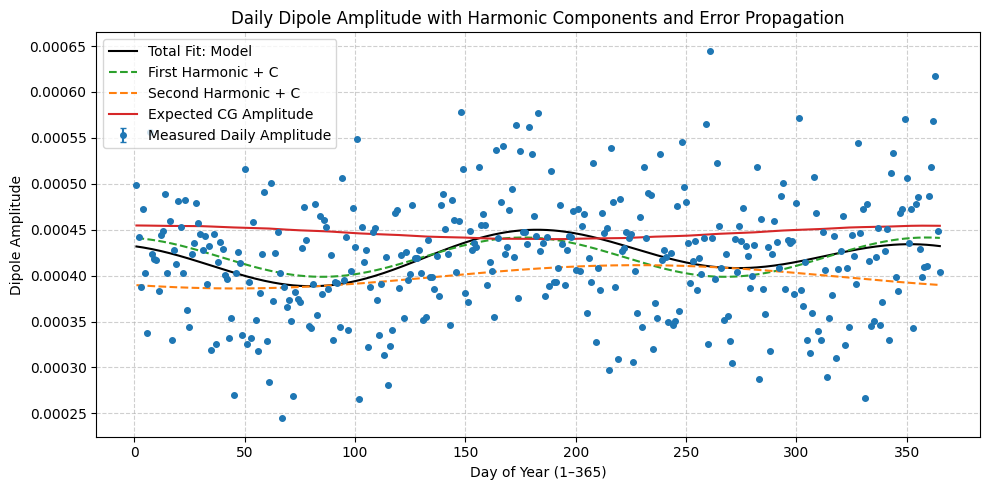

In [9]:
import os
from datetime import datetime
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, get_body_barycentric_posvel
from mapFunctions import getMap

# Constants
DAILY_DIR = '/data/user/fmcnally/anisotropy/maps/merged_daily'
ALL_DATA_FILE = '/data/user/fmcnally/anisotropy/maps/merged/IC86_N10_sid.fits'
CR_GAMMA = 2.5
C_KM_S = 299_792.458  # Speed of light
NBINS_RA = 24

# Declination correction factor 
delta_min = np.radians(-90)
delta_max = np.radians(-30)
numerator = 2 * (np.sin(delta_min) - np.sin(delta_max))
denominator = (
    delta_min - delta_max +
    np.cos(delta_min) * np.sin(delta_min) -
    np.cos(delta_max) * np.sin(delta_max)
)
correction_factor = numerator / denominator

# Projection angle for CG effect
epsilon = np.radians(23.4)

# Dipole model
def acos_func(x, A, phi):
    return A * np.cos(np.radians(x) + phi)['*

# RA projection
def returnRI(relint_map, relerr_map, ramin=0, ramax=360, nbins=24):
    degree = np.pi / 180
    ramin *= degree
    ramax *= degree
    rabins = np.linspace(ramin, ramax, nbins + 1)
    nside = hp.npix2nside(len(relint_map))
    theta, phi = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
    phiBins = np.digitize(phi, rabins) - 1
    cut = (relint_map != hp.UNSEEN)

    ri, sigmay = np.zeros((2, nbins))
    for i in range(nbins):
        phiCut = (phiBins == i)
        c0 = cut * phiCut
        if np.any(c0):
            ri[i] = np.mean(relint_map[c0])
            sigmay[i] = np.sqrt(np.sum(relerr_map[c0] ** 2)) / c0.sum()
        else:
            ri[i] = sigmay[i] = np.nan

    dx = (ramax - ramin) / (2 * nbins)
    ra = np.linspace(ramin + dx, ramax - dx, nbins) / degree
    return ra, ri, dx * np.ones(nbins) / degree, sigmay

# CG expected amplitude using Earth velocity from astropy
def expected_amplitude_astropy(utc_date):
    t = Time(utc_date, scale='utc')
    with solar_system_ephemeris.set('builtin'):
        _, vel = get_body_barycentric_posvel('earth', t)
    v_mag = vel.norm().to(u.km/u.s).value
    return (CR_GAMMA + 2) * (v_mag / C_KM_S)

# Load full-year average map
all_relint = getMap([ALL_DATA_FILE], mapName='relint', smooth=10, verbose=False, mask=True)

# Main Loop 
amplitudes_raw, amplitudes_corr, amplitude_errors, expected_amps, days_of_year = [], [], [], [], []

for doy in range(1, 366):
    try:
        date = datetime.strptime(f'2025-{doy:03d}', '%Y-%j')
        fn = f"{DAILY_DIR}/IC86_N10_sid_{date.month:02d}-{date.day:02d}.fits"
        if not os.path.isfile(fn):
            continue

        relint_day = getMap([fn], mapName='relint', smooth=10, verbose=False, mask=True)
        if relint_day is None or all_relint is None:
            continue

        diff_map = relint_day - all_relint
        nside = hp.get_nside(diff_map)
        theta, _ = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))

        # Apply southern sky mask
        mask = (theta < np.pi / 2) | (~np.isfinite(diff_map)) | (diff_map == 0) | (diff_map == hp.UNSEEN)
        diff_map[mask] = hp.UNSEEN

        # Create combined error map (σ_total = sqrt(σ_day^2 + σ_all^2))
        err_day_map = np.full_like(diff_map, 1e-5)
        err_all_map = np.full_like(diff_map, 1e-5)
        err_combined = np.sqrt(err_day_map**2 + err_all_map**2)

        # Project to RA
        ra_vals, ri_vals, _, sigmay = returnRI(diff_map, err_combined, ramin=0, ramax=360, nbins=NBINS_RA)
        fit_mask = np.isfinite(ri_vals)
        if np.sum(fit_mask) < 5:
            continue

        # Fit cosine function with propagated errors
        popt, pcov = curve_fit(acos_func, ra_vals[fit_mask], ri_vals[fit_mask], sigma=sigmay[fit_mask],
                               bounds=([0, 0], [0.01, 2*np.pi]), absolute_sigma=True)
        A_raw, phi = popt
        A_err = np.sqrt(pcov[0, 0])  # Error in amplitude

        A_corr = correction_factor * A_raw
        A_corr_err = correction_factor * A_err

        amplitudes_raw.append(A_raw)
        amplitudes_corr.append(A_corr)
        amplitude_errors.append(A_corr_err)
        expected_amps.append(expected_amplitude_astropy(date))
        days_of_year.append(doy)

    except Exception as e:
        print(f"[DOY {doy}] Error: {e}")
        continue

# Harmonic Fit Model
def custom_model(day, A, phi1, B, phi2, C):
    omega = 2 * np.pi / 365.25
    return A * (np.cos(omega * day - phi1))**2 + B * np.cos(omega * day - phi2) + C

# Convert to arrays
doy_array = np.array(days_of_year)
amp_array = np.array(amplitudes_corr)
amp_errors = np.array(amplitude_errors)

# Fit with error weights
p0 = [4e-4, 0.0, 1e-4, 0.0, 0.0]
popt, pcov = curve_fit(custom_model, doy_array, amp_array, sigma=amp_errors, absolute_sigma=True, p0=p0)
perr = np.sqrt(np.diag(pcov))

# Unpack and evaluate fit
A, phi1, B, phi2, C = popt
omega = 2 * np.pi / 365.25
fit_curve = custom_model(doy_array, A, phi1, B, phi2, C)
first_harmonic = A * (np.cos(omega * doy_array - phi1))**2
second_harmonic = B * np.cos(omega * doy_array - phi2)

# Print Results
print(f"\nFit parameters with uncertainties:")
print(f"  A    = {A:.4e} ± {perr[0]:.1e}")
print(f"  phi1 = {phi1:.2f} ± {perr[1]:.2f} rad")
print(f"  B    = {B:.4e} ± {perr[2]:.1e}")
print(f"  phi2 = {phi2:.2f} ± {perr[3]:.2f} rad")
print(f"  C    = {C:.4e} ± {perr[4]:.1e}")
print(f"  Mean amplitude = {np.mean(amp_array):.4e}")

print(f"\nSecond Harmonic Component: B * cos(omega * t - phi2)")
print(f"  Min amplitude = {np.min(second_harmonic):.4e}")
print(f"  Max amplitude = {np.max(second_harmonic):.4e}")

# Plotting
plt.figure(figsize=(10, 5))
plt.errorbar(days_of_year, amp_array, yerr=amp_errors, fmt='o', markersize=4, label='Measured Daily Amplitude', color='tab:blue', capsize=2)
plt.plot(doy_array, fit_curve, '-', color='black', linewidth=1.5, label='Total Fit: Model')
plt.plot(doy_array, first_harmonic + C, '--', color='tab:green', label='First Harmonic + C')
plt.plot(doy_array, second_harmonic + C, '--', color='tab:orange', label='Second Harmonic + C')
plt.plot(doy_array, np.array(expected_amps), '-', color='tab:red', linewidth=1.5, label='Expected CG Amplitude')

plt.xlabel('Day of Year (1–365)')
plt.ylabel('Dipole Amplitude')
plt.title('Daily Dipole Amplitude with Harmonic Components and Error Propagation')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('daily_dipole_amplitude_with_harmonics_and_errors.png', dpi=300)
plt.show()


Fit parameters with uncertainties:
  A    = 4.2807e-05 ± 2.0e-06
  phi1 = -0.11 ± 0.02 rad
  B    = -1.2682e-05 ± 1.0e-06
  phi2 = 0.79 ± 0.08 rad
  C    = 3.9871e-04 ± 1.2e-06
  Mean amplitude = 4.2011e-04


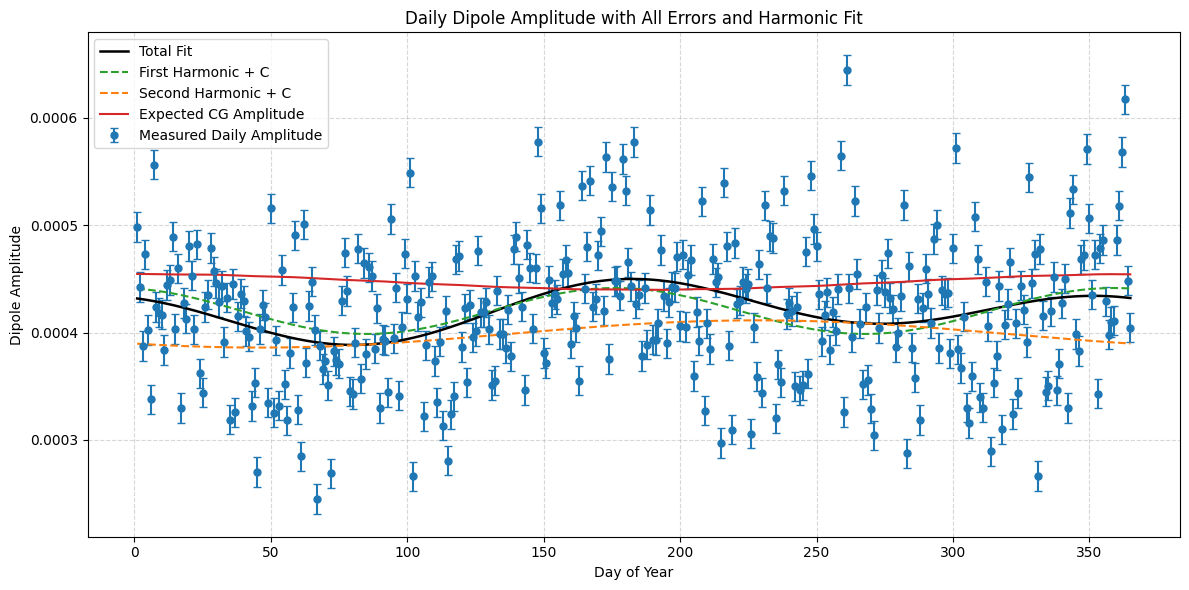

In [8]:
import os
from datetime import datetime
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, get_body_barycentric_posvel
from mapFunctions import getMap

# Constants
DAILY_DIR = '/data/user/fmcnally/anisotropy/maps/merged_daily'
ALL_DATA_FILE = '/data/user/fmcnally/anisotropy/maps/merged/IC86_N10_sid.fits'
CR_GAMMA = 2.5
C_KM_S = 299_792.458
NBINS_RA = 24

# Declination correction factor 
delta_min = np.radians(-90)
delta_max = np.radians(-30)
numerator = 2 * (np.sin(delta_min) - np.sin(delta_max))
denominator = (
    delta_min - delta_max +
    np.cos(delta_min) * np.sin(delta_min) -
    np.cos(delta_max) * np.sin(delta_max)
)
correction_factor = numerator / denominator

# Dipole model
def acos_func(x, A, phi):
    return A * np.cos(np.radians(x) + phi)

# RA projection
def returnRI(relint_map, relerr_map, ramin=0, ramax=360, nbins=24):
    degree = np.pi / 180
    ramin *= degree
    ramax *= degree
    rabins = np.linspace(ramin, ramax, nbins + 1)
    nside = hp.npix2nside(len(relint_map))
    theta, phi = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
    phiBins = np.digitize(phi, rabins) - 1
    cut = (relint_map != hp.UNSEEN)

    ri, sigmay = np.zeros((2, nbins))
    for i in range(nbins):
        phiCut = (phiBins == i)
        c0 = cut * phiCut
        if np.any(c0):
            ri[i] = np.mean(relint_map[c0])
            sigmay[i] = np.sqrt(np.sum(relerr_map[c0] ** 2)) / c0.sum()
        else:
            ri[i] = sigmay[i] = np.nan

    dx = (ramax - ramin) / (2 * nbins)
    ra = np.linspace(ramin + dx, ramax - dx, nbins) / degree
    return ra, ri, dx * np.ones(nbins) / degree, sigmay

# Expected CG amplitude from astropy
def expected_amplitude_astropy(utc_date):
    t = Time(utc_date, scale='utc')
    with solar_system_ephemeris.set('builtin'):
        _, vel = get_body_barycentric_posvel('earth', t)
    v_mag = vel.norm().to(u.km/u.s).value
    return (CR_GAMMA + 2) * (v_mag / C_KM_S)

# Load all-data map
all_relint = getMap([ALL_DATA_FILE], mapName='relint', smooth=10, verbose=False, mask=True)

# Lists to collect results
amplitudes_corr, amplitude_errors, expected_amps, days_of_year = [], [], [], []

for doy in range(1, 366):
    try:
        date = datetime.strptime(f'2025-{doy:03d}', '%Y-%j')
        fn = f"{DAILY_DIR}/IC86_N10_sid_{date.month:02d}-{date.day:02d}.fits"
        if not os.path.isfile(fn):
            continue

        relint_day = getMap([fn], mapName='relint', smooth=10, verbose=False, mask=True)
        if relint_day is None or all_relint is None:
            continue

        diff_map = relint_day - all_relint
        nside = hp.get_nside(diff_map)
        theta, _ = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
        mask = (theta < np.pi / 2) | (~np.isfinite(diff_map)) | (diff_map == 0) | (diff_map == hp.UNSEEN)
        diff_map[mask] = hp.UNSEEN

        err_day_map = np.full_like(diff_map, 5e-4)
        err_all_map = np.full_like(diff_map, 5e-4)
        err_combined = np.sqrt(err_day_map**2 + err_all_map**2)

        ra_vals, ri_vals, _, sigmay = returnRI(diff_map, err_combined, ramin=0, ramax=360, nbins=NBINS_RA)
        fit_mask = np.isfinite(ri_vals)
        if np.sum(fit_mask) < 5:
            continue

        popt, pcov = curve_fit(acos_func, ra_vals[fit_mask], ri_vals[fit_mask], sigma=sigmay[fit_mask],
                               bounds=([0, 0], [0.01, 2*np.pi]), absolute_sigma=True)
        A_raw, phi = popt
        A_err = np.sqrt(pcov[0, 0])
        A_corr = correction_factor * A_raw
        A_corr_err = correction_factor * A_err

        amplitudes_corr.append(A_corr)
        amplitude_errors.append(A_corr_err)
        expected_amps.append(expected_amplitude_astropy(date))
        days_of_year.append(doy)

    except Exception as e:
        print(f"[DOY {doy}] Error: {e}")
        continue

# Harmonic model fit
def custom_model(day, A, phi1, B, phi2, C):
    omega = 2 * np.pi / 365.25
    return A * (np.cos(omega * day - phi1))**2 + B * np.cos(omega * day - phi2) + C

# Convert to arrays
doy_array = np.array(days_of_year)
amp_array = np.array(amplitudes_corr)
amp_errors = np.array(amplitude_errors)
expected_amps = np.array(expected_amps)

# Fit the model
p0 = [4e-4, 0.0, 1e-4, 0.0, 0.0]
popt, pcov = curve_fit(custom_model, doy_array, amp_array, sigma=amp_errors, absolute_sigma=True, p0=p0)
perr = np.sqrt(np.diag(pcov))
A, phi1, B, phi2, C = popt
omega = 2 * np.pi / 365.25
fit_curve = custom_model(doy_array, A, phi1, B, phi2, C)
first_harmonic = A * (np.cos(omega * doy_array - phi1))**2
second_harmonic = B * np.cos(omega * doy_array - phi2)

# Print parameters
print("\nFit parameters with uncertainties:")
print(f"  A    = {A:.4e} ± {perr[0]:.1e}")
print(f"  phi1 = {phi1:.2f} ± {perr[1]:.2f} rad")
print(f"  B    = {B:.4e} ± {perr[2]:.1e}")
print(f"  phi2 = {phi2:.2f} ± {perr[3]:.2f} rad")
print(f"  C    = {C:.4e} ± {perr[4]:.1e}")
print(f"  Mean amplitude = {np.mean(amp_array):.4e}")

# Plotting
plt.figure(figsize=(12, 6))

plt.errorbar(
    doy_array, amp_array, yerr=amp_errors,
    fmt='o', markersize=5, capsize=3,
    label='Measured Daily Amplitude', color='tab:blue'
)

plt.plot(doy_array, fit_curve, '-', color='black', linewidth=1.8, label='Total Fit')
plt.plot(doy_array, first_harmonic + C, '--', color='tab:green', label='First Harmonic + C')
plt.plot(doy_array, second_harmonic + C, '--', color='tab:orange', label='Second Harmonic + C')
plt.plot(doy_array, expected_amps, '-', color='tab:red', linewidth=1.5, label='Expected CG Amplitude')

plt.xlabel('Day of Year')
plt.ylabel('Dipole Amplitude')
plt.title('Daily Dipole Amplitude with All Errors and Harmonic Fit')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('daily_dipole_amplitude_with_all_errors.png', dpi=300)
plt.show()


Fit parameters with uncertainties:
  A    = 4.2807e-05 ± 2.7e-05
  phi1 = -0.11 ± 0.31 rad
  B    = -1.2682e-05 ± 1.3e-05
  phi2 = 0.79 ± 1.06 rad
  C    = 3.9871e-04 ± 1.6e-05
  Mean amplitude = 4.2011e-04
  Error bar range: 1.81e-04 to 1.81e-04

Sample errors:
  DOY 1: A = 4.984e-04 ± 1.8e-04
  DOY 92: A = 3.925e-04 ± 1.8e-04
  DOY 183: A = 5.774e-04 ± 1.8e-04
  DOY 274: A = 4.540e-04 ± 1.8e-04
  DOY 365: A = 4.045e-04 ± 1.8e-04


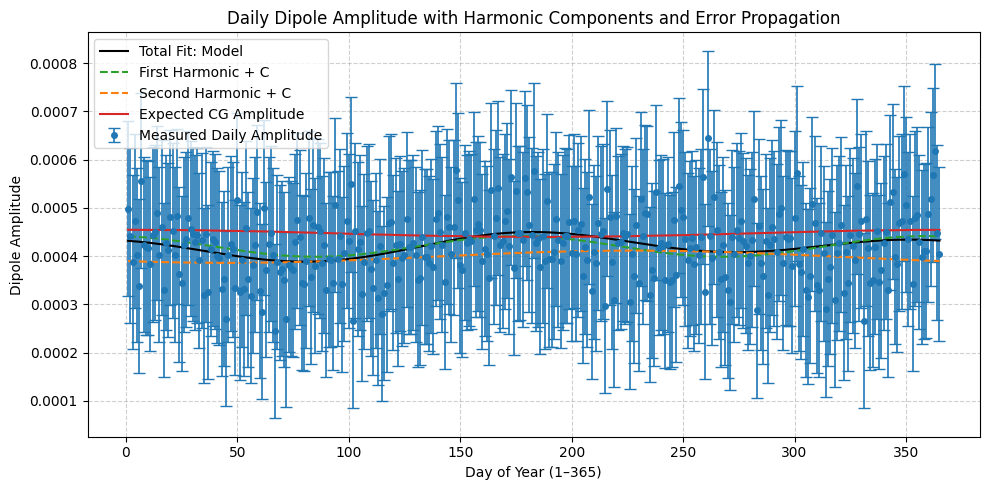

In [1]:
import os
from datetime import datetime
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, get_body_barycentric_posvel
from mapFunctions import getMap

# Constants
DAILY_DIR = '/data/user/fmcnally/anisotropy/maps/merged_daily'
ALL_DATA_FILE = '/data/user/fmcnally/anisotropy/maps/merged/IC86_N10_sid.fits'
CR_GAMMA = 2.5
C_KM_S = 299_792.458
NBINS_RA = 24

# Declination correction
delta_min = np.radians(-90)
delta_max = np.radians(-30)
numerator = 2 * (np.sin(delta_min) - np.sin(delta_max))
denominator = (
    delta_min - delta_max +
    np.cos(delta_min) * np.sin(delta_min) -
    np.cos(delta_max) * np.sin(delta_max)
)
correction_factor = numerator / denominator

def acos_func(x, A, phi):
    return A * np.cos(np.radians(x) + phi)

def returnRI(relint_map, relerr_map, ramin=0, ramax=360, nbins=24):
    degree = np.pi / 180
    ramin *= degree
    ramax *= degree
    rabins = np.linspace(ramin, ramax, nbins + 1)
    nside = hp.npix2nside(len(relint_map))
    theta, phi = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
    phiBins = np.digitize(phi, rabins) - 1
    cut = (relint_map != hp.UNSEEN)

    ri, sigmay = np.zeros((2, nbins))
    for i in range(nbins):
        phiCut = (phiBins == i)
        c0 = cut * phiCut
        if np.any(c0):
            ri[i] = np.mean(relint_map[c0])
            sigmay[i] = np.sqrt(np.sum(relerr_map[c0] ** 2)) / c0.sum()
        else:
            ri[i] = sigmay[i] = np.nan

    sigmay = np.where((sigmay == 0) | (~np.isfinite(sigmay)), np.nan, sigmay)
    dx = (ramax - ramin) / (2 * nbins)
    ra = np.linspace(ramin + dx, ramax - dx, nbins) / degree
    return ra, ri, dx * np.ones(nbins) / degree, sigmay

def expected_amplitude_astropy(utc_date):
    t = Time(utc_date, scale='utc')
    with solar_system_ephemeris.set('builtin'):
        _, vel = get_body_barycentric_posvel('earth', t)
    v_mag = vel.norm().to(u.km/u.s).value
    return (CR_GAMMA + 2) * (v_mag / C_KM_S)

# Load full-year map
all_relint = getMap([ALL_DATA_FILE], mapName='relint', smooth=10, verbose=False, mask=True)

amplitudes_raw, amplitudes_corr, amplitude_errors, expected_amps, days_of_year = [], [], [], [], []

for doy in range(1, 366):
    try:
        date = datetime.strptime(f'2025-{doy:03d}', '%Y-%j')
        fn = f"{DAILY_DIR}/IC86_N10_sid_{date.month:02d}-{date.day:02d}.fits"
        if not os.path.isfile(fn):
            continue

        relint_day = getMap([fn], mapName='relint', smooth=10, verbose=False, mask=True)
        if relint_day is None or all_relint is None:
            continue

        diff_map = relint_day - all_relint
        nside = hp.get_nside(diff_map)
        theta, _ = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))

        mask = (theta < np.pi / 2) | (~np.isfinite(diff_map)) | (diff_map == 0) | (diff_map == hp.UNSEEN)
        diff_map[mask] = hp.UNSEEN

        # Use Poisson-based error estimate: sigma ≈ 1/sqrt(Npix)
        n_effective = np.sum(~mask)
        est_err_day = 1 / np.sqrt(n_effective) if n_effective > 0 else 1e-3
        est_err_all = 0.5 * est_err_day  # Average map has more stats

        err_day_map = np.full_like(diff_map, est_err_day)
        err_all_map = np.full_like(diff_map, est_err_all)
        err_combined = np.sqrt(err_day_map**2 + err_all_map**2)

        ra_vals, ri_vals, _, sigmay = returnRI(diff_map, err_combined, ramin=0, ramax=360, nbins=NBINS_RA)
        fit_mask = np.isfinite(ri_vals) & np.isfinite(sigmay)
        if np.sum(fit_mask) < 5:
            continue

        popt, pcov = curve_fit(acos_func, ra_vals[fit_mask], ri_vals[fit_mask],
                               sigma=sigmay[fit_mask], bounds=([0, 0], [0.01, 2*np.pi]),
                               absolute_sigma=True)
        A_raw, phi = popt
        A_err = np.sqrt(pcov[0, 0])

        A_corr = correction_factor * A_raw
        A_corr_err = correction_factor * A_err

        amplitudes_raw.append(A_raw)
        amplitudes_corr.append(A_corr)
        amplitude_errors.append(A_corr_err)
        expected_amps.append(expected_amplitude_astropy(date))
        days_of_year.append(doy)

    except Exception as e:
        print(f"[DOY {doy}] Error: {e}")
        continue

# Harmonic model
def custom_model(day, A, phi1, B, phi2, C):
    omega = 2 * np.pi / 365.25
    return A * (np.cos(omega * day - phi1))**2 + B * np.cos(omega * day - phi2) + C

doy_array = np.array(days_of_year)
amp_array = np.array(amplitudes_corr)
amp_errors = np.array(amplitude_errors)

p0 = [4e-4, 0.0, 1e-4, 0.0, 0.0]
popt, pcov = curve_fit(custom_model, doy_array, amp_array, sigma=amp_errors, absolute_sigma=True, p0=p0)
perr = np.sqrt(np.diag(pcov))

A, phi1, B, phi2, C = popt
omega = 2 * np.pi / 365.25
fit_curve = custom_model(doy_array, A, phi1, B, phi2, C)
first_harmonic = A * (np.cos(omega * doy_array - phi1))**2
second_harmonic = B * np.cos(omega * doy_array - phi2)

print(f"\nFit parameters with uncertainties:")
print(f"  A    = {A:.4e} ± {perr[0]:.1e}")
print(f"  phi1 = {phi1:.2f} ± {perr[1]:.2f} rad")
print(f"  B    = {B:.4e} ± {perr[2]:.1e}")
print(f"  phi2 = {phi2:.2f} ± {perr[3]:.2f} rad")
print(f"  C    = {C:.4e} ± {perr[4]:.1e}")
print(f"  Mean amplitude = {np.mean(amp_array):.4e}")
print(f"  Error bar range: {np.nanmin(amp_errors):.2e} to {np.nanmax(amp_errors):.2e}")

# Optional sample
print("\nSample errors:")
for i in range(0, len(amp_errors), len(amp_errors)//4):
    print(f"  DOY {doy_array[i]}: A = {amp_array[i]:.3e} ± {amp_errors[i]:.1e}")

# Plot
plt.figure(figsize=(10, 5))
plt.errorbar(days_of_year, amp_array, yerr=amp_errors, fmt='o', markersize=4,
             label='Measured Daily Amplitude', color='tab:blue', capsize=4, elinewidth=1.2)
plt.plot(doy_array, fit_curve, '-', color='black', linewidth=1.5, label='Total Fit: Model')
plt.plot(doy_array, first_harmonic + C, '--', color='tab:green', label='First Harmonic + C')
plt.plot(doy_array, second_harmonic + C, '--', color='tab:orange', label='Second Harmonic + C')
plt.plot(doy_array, np.array(expected_amps), '-', color='tab:red', linewidth=1.5, label='Expected CG Amplitude')

plt.xlabel('Day of Year (1–365)')
plt.ylabel('Dipole Amplitude')
plt.title('Daily Dipole Amplitude with Harmonic Components and Error Propagation')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('daily_dipole_amplitude_with_harmonics_and_errors.png', dpi=300)
plt.show()



Fit parameters:
  A    = 4.2807e-05
  phi1 = -0.11 rad
  B    = 1.2682e-05
  phi2 = -2.35 rad
  C    = 3.1439e+01 (baseline amplitude)
  Mean amplitude = 4.2011e-04


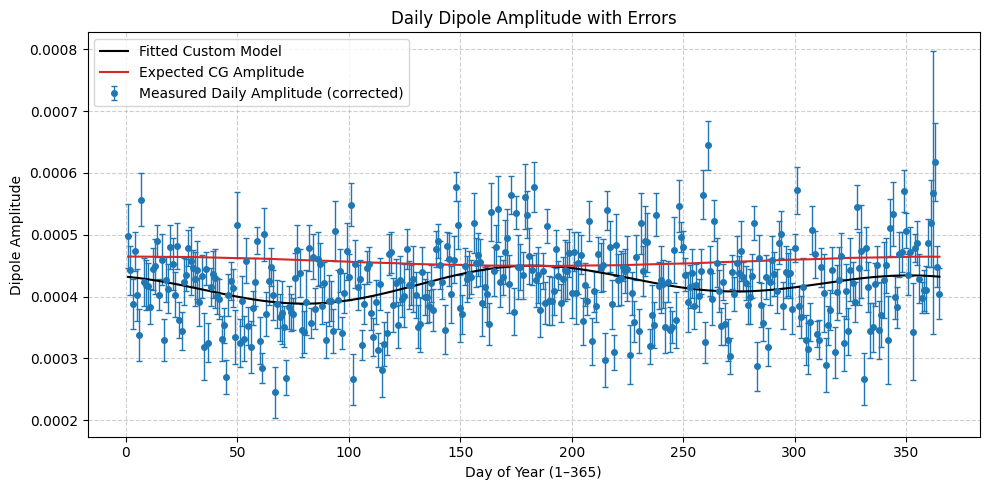

In [1]:
import os
from datetime import datetime
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, get_body_barycentric_posvel

from mapFunctions import getMap

# Constants
DAILY_DIR = '/data/user/fmcnally/anisotropy/maps/merged_daily'
ALL_DATA_FILE = '/data/user/fmcnally/anisotropy/maps/merged/IC86_N10_sid.fits'
CR_GAMMA = 2.6
C_KM_S = 299_792.458  # Speed of light
NBINS_RA = 24

# Declination correction factor (same as monthly code) 
delta_min = np.radians(-90)
delta_max = np.radians(-30)
numerator = 2 * (np.sin(delta_min) - np.sin(delta_max))
denominator = (
    delta_min - delta_max +
    np.cos(delta_min) * np.sin(delta_min) -
    np.cos(delta_max) * np.sin(delta_max)
)
correction_factor = numerator / denominator

# Dipole model
def acos_func(x, A, phi):
    return A * np.cos(np.radians(x) + phi)

# RA projection (copied from monthly)
def returnRI(relint_map, relerr_map, ramin=0, ramax=360, nbins=24):
    degree = np.pi / 180
    ramin *= degree
    ramax *= degree
    rabins = np.linspace(ramin, ramax, nbins + 1)
    nside = hp.npix2nside(len(relint_map))
    theta, phi = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
    phiBins = np.digitize(phi, rabins) - 1
    cut = (relint_map != hp.UNSEEN)

    ri, sigmay = np.zeros((2, nbins))
    for i in range(nbins):
        phiCut = (phiBins == i)
        c0 = cut * phiCut
        if np.any(c0):
            ri[i] = np.mean(relint_map[c0])
            sigmay[i] = np.sqrt(np.sum(relerr_map[c0] ** 2)) / c0.sum()
        else:
            ri[i] = sigmay[i] = np.nan

    dx = (ramax - ramin) / (2 * nbins)
    ra = np.linspace(ramin + dx, ramax - dx, nbins) / degree
    return ra, ri, dx * np.ones(nbins) / degree, sigmay

# CG model
def expected_amplitude_astropy(utc_date):
    t = Time(utc_date, scale='utc')
    with solar_system_ephemeris.set('builtin'):
        _, vel = get_body_barycentric_posvel('earth', t)
    v_mag = vel.norm().to(u.km/u.s).value
    return (CR_GAMMA + 2) * (v_mag / C_KM_S)

# Load full-year map
all_relint = getMap([ALL_DATA_FILE], mapName='relint', smooth=10, verbose=False, mask=True)

# Main loop
amplitudes_raw, amplitudes_corr, expected_amps, days_of_year, amplitude_errs = [], [], [], [], []

for doy in range(1, 366):
    try:
        date = datetime.strptime(f'2025-{doy:03d}', '%Y-%j')
        fn = f"{DAILY_DIR}/IC86_N10_sid_{date.month:02d}-{date.day:02d}.fits"
        if not os.path.isfile(fn):
            continue

        relint_day = getMap([fn], mapName='relint', smooth=10, verbose=False, mask=True)
        if relint_day is None or all_relint is None:
            continue

        diff_map = relint_day - all_relint
        nside = hp.get_nside(diff_map)
        theta, _ = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))

        # Apply southern sky mask
        mask = (theta < np.pi / 2) | (~np.isfinite(diff_map)) | (diff_map == 0) | (diff_map == hp.UNSEEN)
        diff_map[mask] = hp.UNSEEN
        err_map = np.full_like(diff_map, 1e-5)

        # Project and fit daily cosine model
        ra_vals, ri_vals, _, sigmay = returnRI(diff_map, err_map, ramin=0, ramax=360, nbins=NBINS_RA)
        fit_mask = np.isfinite(ri_vals)
        if np.sum(fit_mask) < 5:
            continue

        popt, pcov = curve_fit(acos_func, ra_vals[fit_mask], ri_vals[fit_mask], sigma=sigmay[fit_mask],
                               bounds=([0, 0], [0.01, 2*np.pi]))
        A_raw, phi = popt
        A_raw_err = np.sqrt(pcov[0, 0])  # 1-sigma error on amplitude
        A_corr = correction_factor * A_raw
        A_corr_err = correction_factor * A_raw_err

        # Store results
        amplitudes_raw.append(A_raw)
        amplitudes_corr.append(A_corr)
        amplitude_errs.append(A_corr_err)
        expected_amps.append(expected_amplitude_astropy(date))
        days_of_year.append(doy)

    except Exception as e:
        print(f"[DOY {doy}] Error: {e}")
        continue

# Fit custom model to full-year amplitude trend
def custom_model(day, A, phi1, B, phi2, C):
    omega = 2 * np.pi / 365.25
    return A * (np.cos(omega * day - phi1))**2 + B * (np.cos(omega * day - phi2) + C)

doy_array = np.array(days_of_year)
amp_array = np.array(amplitudes_corr)
amp_err_array = np.array(amplitude_errs)

p0 = [4e-4, 0.0, 1e-4, 0.0, 0.0]
popt, _ = curve_fit(custom_model, doy_array, amp_array, p0=p0)
A, phi1, B, phi2, C = popt
fit_curve = custom_model(doy_array, *popt)

# Print fitted model parameters
print(f"\nFit parameters:")
print(f"  A    = {A:.4e}")
print(f"  phi1 = {phi1:.2f} rad")
print(f"  B    = {B:.4e}")
print(f"  phi2 = {phi2:.2f} rad")
print(f"  C    = {C:.4e} (baseline amplitude)")
print(f"  Mean amplitude = {np.mean(amp_array):.4e}")

# Plot with error bars on blue points
plt.figure(figsize=(10, 5))
plt.errorbar(days_of_year, amp_array, yerr=amp_err_array, fmt='o', markersize=4,
             label='Measured Daily Amplitude (corrected)', color='tab:blue', capsize=2, elinewidth=1)
plt.plot(doy_array, fit_curve, '-', color='black', linewidth=1.5, label='Fitted Custom Model')
plt.plot(doy_array, np.array(expected_amps), '-', color='tab:red', linewidth=1.5, label='Expected CG Amplitude')

plt.xlabel('Day of Year (1–365)')
plt.ylabel('Dipole Amplitude')
plt.title('Daily Dipole Amplitude with Errors')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('daily_dipole_amplitude_with_errors.png', dpi=300)
plt.show()



Fit parameters (NO mean subtraction):
  A    = 4.2807e-05 ± 9.2e-06
  phi1 = -0.11 ± 0.11 rad
  B    = 1.2682e-05 ± 4.6e-06
  phi2 = -2.35 ± 0.36 rad
  C    = 3.1439e+01 ± 1.1e+01
  Mean amplitude = 4.2011e-04


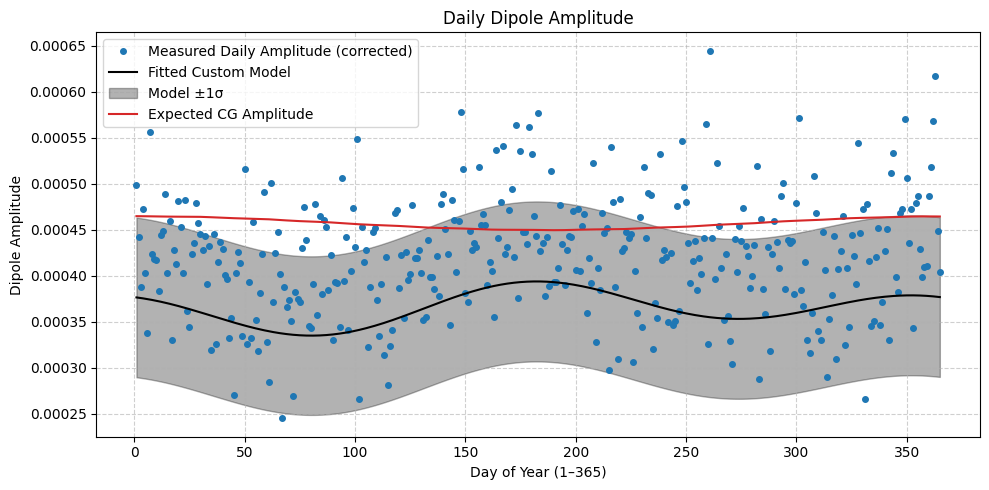

In [2]:
import os
from datetime import datetime
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, get_body_barycentric_posvel

from mapFunctions import getMap

# Constants
DAILY_DIR = '/data/user/fmcnally/anisotropy/maps/merged_daily'
ALL_DATA_FILE = '/data/user/fmcnally/anisotropy/maps/merged/IC86_N10_sid.fits'
CR_GAMMA = 2.6
C_KM_S = 299_792.458  # Speed of light
NBINS_RA = 24

# Declination correction factor (same as monthly code)
delta_min = np.radians(-90)
delta_max = np.radians(-30)
numerator = 2 * (np.sin(delta_min) - np.sin(delta_max))
denominator = (
    delta_min - delta_max +
    np.cos(delta_min) * np.sin(delta_min) -
    np.cos(delta_max) * np.sin(delta_max)
)
correction_factor = numerator / denominator

# Dipole model
def acos_func(x, A, phi):
    return A * np.cos(np.radians(x) + phi)

# RA projection (copied from monthly)
def returnRI(relint_map, relerr_map, ramin=0, ramax=360, nbins=24):
    degree = np.pi / 180
    ramin *= degree
    ramax *= degree
    rabins = np.linspace(ramin, ramax, nbins + 1)
    nside = hp.npix2nside(len(relint_map))
    theta, phi = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
    phiBins = np.digitize(phi, rabins) - 1
    cut = (relint_map != hp.UNSEEN)

    ri, sigmay = np.zeros((2, nbins))
    for i in range(nbins):
        phiCut = (phiBins == i)
        c0 = cut * phiCut
        if np.any(c0):
            ri[i] = np.mean(relint_map[c0])
            sigmay[i] = np.sqrt(np.sum(relerr_map[c0] ** 2)) / c0.sum()
        else:
            ri[i] = sigmay[i] = np.nan

    dx = (ramax - ramin) / (2 * nbins)
    ra = np.linspace(ramin + dx, ramax - dx, nbins) / degree
    return ra, ri, dx * np.ones(nbins) / degree, sigmay

# CG model
def expected_amplitude_astropy(utc_date):
    t = Time(utc_date, scale='utc')
    with solar_system_ephemeris.set('builtin'):
        _, vel = get_body_barycentric_posvel('earth', t)
    v_mag = vel.norm().to(u.km/u.s).value
    return (CR_GAMMA + 2) * (v_mag / C_KM_S)

# Load full-year map
all_relint = getMap([ALL_DATA_FILE], mapName='relint', smooth=10, verbose=False, mask=True)

# Loop through days
amplitudes_raw, amplitudes_corr, expected_amps, days_of_year = [], [], [], []

for doy in range(1, 366):
    try:
        date = datetime.strptime(f'2025-{doy:03d}', '%Y-%j')
        fn = f"{DAILY_DIR}/IC86_N10_sid_{date.month:02d}-{date.day:02d}.fits"
        if not os.path.isfile(fn):
            continue

        relint_day = getMap([fn], mapName='relint', smooth=10, verbose=False, mask=True)
        if relint_day is None or all_relint is None:
            continue

        diff_map = relint_day - all_relint
        nside = hp.get_nside(diff_map)
        theta, _ = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))

        # Apply same mask as monthly (southern sky only)
        mask = (theta < np.pi / 2) | (~np.isfinite(diff_map)) | (diff_map == 0) | (diff_map == hp.UNSEEN)
        diff_map[mask] = hp.UNSEEN
        err_map = np.full_like(diff_map, 1e-5)

        # Project and fit
        ra_vals, ri_vals, _, sigmay = returnRI(diff_map, err_map, ramin=0, ramax=360, nbins=NBINS_RA)
        fit_mask = np.isfinite(ri_vals)
        if np.sum(fit_mask) < 5:
            continue

        popt, _ = curve_fit(acos_func, ra_vals[fit_mask], ri_vals[fit_mask], sigma=sigmay[fit_mask],
                            bounds=([0, 0], [0.01, 2*np.pi]))
        A_raw, phi = popt
        A_corr = correction_factor * A_raw

        amplitudes_raw.append(A_raw)
        amplitudes_corr.append(A_corr)
        expected_amps.append(expected_amplitude_astropy(date))
        days_of_year.append(doy)

    except Exception as e:
        print(f"[DOY {doy}] Error: {e}")
        continue

# Fit custom model
def custom_model(day, A, phi1, B, phi2, C):
    omega = 2 * np.pi / 365.25
    return A * (np.cos(omega * day - phi1))**2 + B * (np.cos(omega * day - phi2) + C)

doy_array = np.array(days_of_year)
amp_array = np.array(amplitudes_corr)

p0 = [4e-4, 0.0, 1e-4, 0.0, 0.0]
popt, pcov = curve_fit(custom_model, doy_array, amp_array, p0=p0)

# Calculate uncertainties on fit parameters
perr = np.sqrt(np.diag(pcov))

# Propagate fit uncertainty to model (±1σ band)
N = 300
param_samples = np.random.multivariate_normal(popt, pcov, size=N)
fit_samples = np.array([custom_model(doy_array, *params) for params in param_samples])
fit_mean = np.mean(fit_samples, axis=0)
fit_std = np.std(fit_samples, axis=0)

# Print fit results
print(f"\nFit parameters (NO mean subtraction):")
print(f"  A    = {popt[0]:.4e} ± {perr[0]:.1e}")
print(f"  phi1 = {popt[1]:.2f} ± {perr[1]:.2f} rad")
print(f"  B    = {popt[2]:.4e} ± {perr[2]:.1e}")
print(f"  phi2 = {popt[3]:.2f} ± {perr[3]:.2f} rad")
print(f"  C    = {popt[4]:.4e} ± {perr[4]:.1e}")
print(f"  Mean amplitude = {np.mean(amp_array):.4e}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(days_of_year, amp_array, 'o', markersize=4, label='Measured Daily Amplitude (corrected)', color='tab:blue')
plt.plot(doy_array, fit_mean, '-', color='black', linewidth=1.5, label='Fitted Custom Model')

# Plot ±1σ band
plt.fill_between(doy_array, fit_mean - fit_std, fit_mean + fit_std, color='black', alpha=0.3, label='Model ±1σ')

plt.plot(doy_array, np.array(expected_amps), '-', color='tab:red', linewidth=1.5, label='Expected CG Amplitude')

plt.xlabel('Day of Year (1–365)')
plt.ylabel('Dipole Amplitude')
plt.title('Daily Dipole Amplitude')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('daily_dipole_amplitude_nocenter.png', dpi=300)
plt.show()


In [67]:
import numpy as np

doy_array = np.array(days_of_year)
amp_array = np.array(amplitudes_corr)
expected_array = np.array(expected_amps)

print("doy_array =", repr(doy_array))
print("amp_array =", repr(amp_array))
print("expected_array =", repr(expected_array))


doy_array = array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 

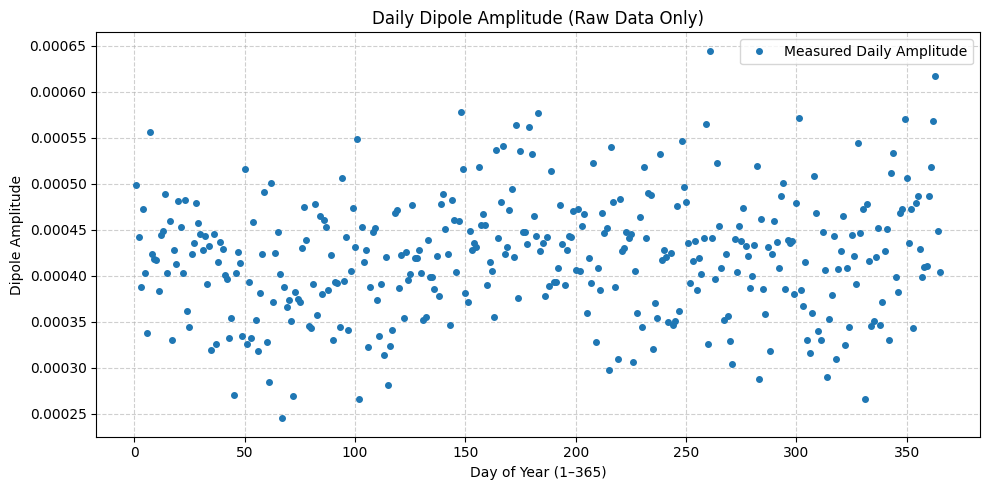

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Input Arrays (already defined from your loop) ---
doy_array = np.array(days_of_year)
amp_array = np.array(amplitudes_corr)

# Plot Raw Data Only ---
plt.figure(figsize=(10, 5))
plt.plot(doy_array, amp_array, 'o', markersize=4, color='tab:blue', label='Measured Daily Amplitude')

plt.xlabel('Day of Year (1–365)')
plt.ylabel('Dipole Amplitude')
plt.title('Daily Dipole Amplitude (Raw Data Only)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('daily_amplitude_raw_only.png', dpi=300)
plt.show()



Fit parameters :
  A    = 4.6643e-05
  phi1 = -0.11 rad
  B    = 1.3819e-05
  phi2 = -2.35 rad
  C    = 3.1439e+01 (baseline amplitude)
  Mean amplitude = 4.5775e-04


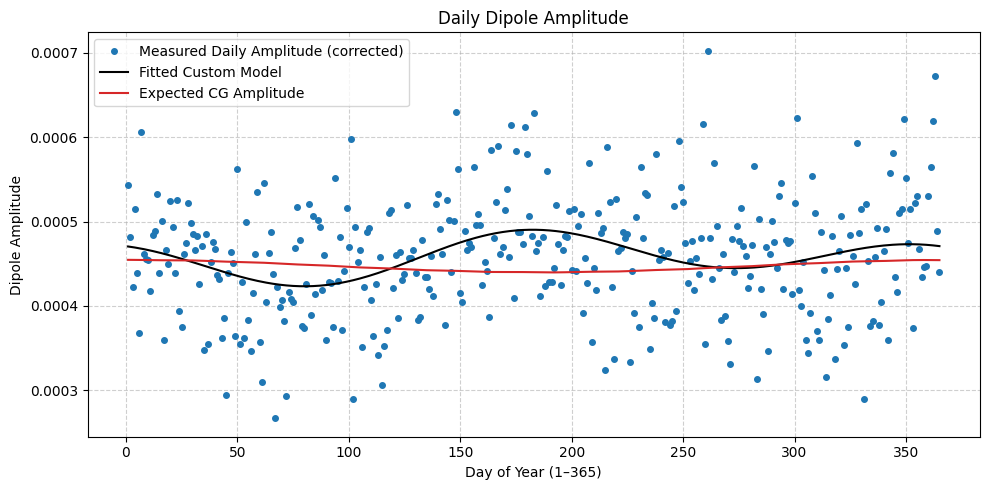

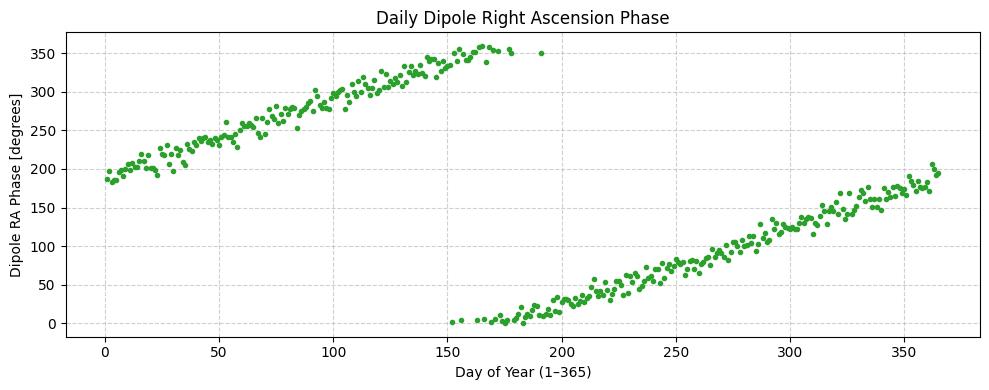

In [2]:
import os
from datetime import datetime
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, get_body_barycentric_posvel

from mapFunctions import getMap

# --- Constants ---
DAILY_DIR = '/data/user/fmcnally/anisotropy/maps/merged_daily'
ALL_DATA_FILE = '/data/user/fmcnally/anisotropy/maps/merged/IC86_N10_sid.fits'
CR_GAMMA = 2.5
C_KM_S = 299_792.458  # Speed of light
NBINS_RA = 24

# Declination correction factor (southern sky only)
delta_min = np.radians(-90)
delta_max = np.radians(-30)
numerator = 2 * (np.sin(delta_min) - np.sin(delta_max))
denominator = (
    delta_min - delta_max +
    np.cos(delta_min) * np.sin(delta_min) -
    np.cos(delta_max) * np.sin(delta_max)
)
correction_factor = numerator / denominator

# Projection correction (Earth tilt)
epsilon = np.radians(23.4)

# Dipole model
def acos_func(x, A, phi):
    return A * np.cos(np.radians(x) + phi)

#  RA projection
def returnRI(relint_map, relerr_map, ramin=0, ramax=360, nbins=24):
    degree = np.pi / 180
    ramin *= degree
    ramax *= degree
    rabins = np.linspace(ramin, ramax, nbins + 1)
    nside = hp.npix2nside(len(relint_map))
    theta, phi = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
    phiBins = np.digitize(phi, rabins) - 1
    cut = (relint_map != hp.UNSEEN)

    ri, sigmay = np.zeros((2, nbins))
    for i in range(nbins):
        phiCut = (phiBins == i)
        c0 = cut * phiCut
        if np.any(c0):
            ri[i] = np.mean(relint_map[c0])
            sigmay[i] = np.sqrt(np.sum(relerr_map[c0] ** 2)) / c0.sum()
        else:
            ri[i] = sigmay[i] = np.nan

    dx = (ramax - ramin) / (2 * nbins)
    ra = np.linspace(ramin + dx, ramax - dx, nbins) / degree
    return ra, ri, dx * np.ones(nbins) / degree, sigmay

# CG model from orbital speed
def expected_amplitude_astropy(utc_date):
    t = Time(utc_date, scale='utc')
    with solar_system_ephemeris.set('builtin'):
        _, vel = get_body_barycentric_posvel('earth', t)
    v_mag = vel.norm().to(u.km/u.s).value
    return (CR_GAMMA + 2) * (v_mag / C_KM_S)

# Load baseline full-year map
all_relint = getMap([ALL_DATA_FILE], mapName='relint', smooth=10, verbose=False, mask=True)

# Storage arrays
amplitudes_raw, amplitudes_corr, expected_amps, days_of_year, ra_phases = [], [], [], [], []

# Main loop over each day
for doy in range(1, 366):
    try:
        date = datetime.strptime(f'2025-{doy:03d}', '%Y-%j')
        fn = f"{DAILY_DIR}/IC86_N10_sid_{date.month:02d}-{date.day:02d}.fits"
        if not os.path.isfile(fn):
            continue

        relint_day = getMap([fn], mapName='relint', smooth=10, verbose=False, mask=True)
        if relint_day is None or all_relint is None:
            continue

        diff_map = relint_day - all_relint
        nside = hp.get_nside(diff_map)
        theta, _ = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))

        # Southern sky only
        mask = (theta < np.pi / 2) | (~np.isfinite(diff_map)) | (diff_map == 0) | (diff_map == hp.UNSEEN)
        diff_map[mask] = hp.UNSEEN
        err_map = np.full_like(diff_map, 1e-5)

        # Project to RA and fit dipole
        ra_vals, ri_vals, _, sigmay = returnRI(diff_map, err_map, ramin=0, ramax=360, nbins=NBINS_RA)
        fit_mask = np.isfinite(ri_vals)
        if np.sum(fit_mask) < 5:
            continue

        popt, _ = curve_fit(acos_func, ra_vals[fit_mask], ri_vals[fit_mask], sigma=sigmay[fit_mask],
                            bounds=([0, 0], [0.01, 2*np.pi]))
        A_raw, phi = popt

        # Corrections
        A_corr = correction_factor * A_raw / np.cos(epsilon)
        ra_phase_deg = (np.degrees(-phi) % 360)  # convert to RA phase

        # Store results
        amplitudes_raw.append(A_raw)
        amplitudes_corr.append(A_corr)
        expected_amps.append(expected_amplitude_astropy(date))
        ra_phases.append(ra_phase_deg)
        days_of_year.append(doy)

    except Exception as e:
        print(f"[DOY {doy}] Error: {e}")
        continue

# Fit seasonal model
def custom_model(day, A, phi1, B, phi2, C):
    omega = 2 * np.pi / 365.25
    return A * (np.cos(omega * day - phi1))**2 + B * (np.cos(omega * day - phi2) + C)

doy_array = np.array(days_of_year)
amp_array = np.array(amplitudes_corr)

p0 = [4e-4, 0.0, 1e-4, 0.0, 0.0]
popt, _ = curve_fit(custom_model, doy_array, amp_array, p0=p0)
A, phi1, B, phi2, C = popt
fit_curve = custom_model(doy_array, *popt)

#Print results
print(f"\nFit parameters :")
print(f"  A    = {A:.4e}")
print(f"  phi1 = {phi1:.2f} rad")
print(f"  B    = {B:.4e}")
print(f"  phi2 = {phi2:.2f} rad")
print(f"  C    = {C:.4e} (baseline amplitude)")
print(f"  Mean amplitude = {np.mean(amp_array):.4e}")

# Plot amplitude vs day
plt.figure(figsize=(10, 5))
plt.plot(days_of_year, amp_array, 'o', markersize=4, label='Measured Daily Amplitude (corrected)', color='tab:blue')
plt.plot(doy_array, fit_curve, '-', color='black', linewidth=1.5, label='Fitted Custom Model')
plt.plot(doy_array, np.array(expected_amps), '-', color='tab:red', linewidth=1.5, label='Expected CG Amplitude')
plt.xlabel('Day of Year (1–365)')
plt.ylabel('Dipole Amplitude')
plt.title('Daily Dipole Amplitude')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('daily_dipole_amplitude_nocenter.png', dpi=300)
plt.show()

# Plot RA dipole phase vs day
plt.figure(figsize=(10, 4))
plt.plot(days_of_year, ra_phases, 'o', markersize=3, color='tab:green')
plt.xlabel('Day of Year (1–365)')
plt.ylabel('Dipole RA Phase [degrees]')
plt.title('Daily Dipole Right Ascension Phase')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('daily_dipole_ra_phase.png', dpi=300)
plt.show()
